# Notebook 4 - Time Series Analysis with Recurrent Neural Network
### Hugo C Marrochio
### Date: Dec 13th 2024

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import matplotlib.dates as mdates


from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity

import seaborn as sns
import plotly.graph_objects as go
import random
plt.rcParams['figure.figsize'] = (8.0, 6.0) #setting figure size
from tensorflow.keras.callbacks import EarlyStopping
#from IPython.display import display


from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from keras.layers import LSTM, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.initializers import HeNormal
from tensorflow.keras.callbacks import TensorBoard






from sklearn.metrics import mean_squared_error

In [199]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import SGD



import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


import warnings 

In [17]:
from auxiliary_functions import *

In [18]:
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()

In [202]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Summary of notebook 4 - Time Series Analysis with Recurrent Neural Network

In this notebook, we will continue the modelling of S&P500 data from kaggle (https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks). The goal is to explore price forecasting using Neural Networks. 

For most of the notebook we will focus on analyzing the Apple stock, for a training period of 2 years and testing the data on a period of 4 months. We consider a rolling window input of $40$ data points.

Even though we do not perform time series cross validation, we do a careful search of hyperparameters for each of the neural network architectures studied: Simple RNN, GRU and LSTM. The metric we analyze in order to search for the best hyperparameters is the Mean Squared Error (MSE). That's both the metric employed as a loss in order to train the networks, as well as calculating the MSE on unseen test data.

We first summarize our findings for the best models (to find the hyperparameter experiments, the reader should go to __Appendices C-E__):


|                       |  Simple RNN           | GRU        | LSTM       |
|:----------------------|:---------------------:|:----------:|:----------:|   
| __A__-Hidden States   |         40-80-40      |   40-80-40 |   40-80-40 |
| __B__ - Activation    |      Relu             |  Relu      |  Relu      |
| __C__ - Dropout       |      0.05             |      0.05  |     0.05   |
| __D__ - Batch         |                2      |      2     |    2       |
| __E__ - Learning Rate |               0.001   |     0.001  |    0.001   |
| __F__ - Optimizer     |              Adam     |     Adam   |  RMSprop   |
| __MSE train__         |           0.0029      |   0.0029   |  0.0035    |
| __MSE test__          |          0.0017       |   0.0011   |     0.0039 |

We were successful in finding reasonable price predictions for the architectures we studied, but we stress that _successful_ really depends on the intended application of the forecast, as well as the metric employed.

One test of robustness of the selected architectures is to perform prediction on different stock data. Surprisingly, we use the network trained on `AAPL` stock to forecast both futher into the future, as well as for different stock symbols. We analyze Walmart, JP Morgan and Chevron, as these stocks are from different industries and the price is different than the `AAPL`stock range it was trained on. We also obtained promising results (notice that MSE is not straightforwardly comparable to training ones as the range of date and scale of prices are different)

|           | Simple RNN, MSE test        | GRU , MSE test        | LSTM, MSE test        |
|:----------|:---------------------------:|:---------------------:|:---------------------:|   
| Apple     |         0.022               |         0.022         |         0.029         |
| Walmart   |         0.0017              |         0.0017        |         0.0022        |
| JP Morgan |         0.020               |         0.020         |         0.028         |
| Chevron   |         0.022               |         0.022         |           0.029       |

For the appendix, we analyze ARIMA forecasting using rolling window of the same size we used for the NN analysis. Interestingly, ARIMA seemed to give a slight improvement of MSE, but it did not capture the overal shape of the price prediction as well as the Neural Networks. In addition, we have to fit an ARIMA model for every block of rolling window - differently than NN, that once we trained we did not update the network weights. 

We also analyzed a naive forecasting: Just forecasting the price of today to tomorrow. Despite this model being quite uninformative, the MSE was the lowest of all the models analyzed. This is just to show how important analyzing other metrics is in order to determine the best forecasting model. In addition, traders most times care more whether a stock will go up or down than the numerical value, so the naive forecasting really brings no real gain for strategizing.





### Notebook 4

#### 0 - Loading Auxiliary Functions and csv Files

    - Load the data we produced in Notebook 1.
    - Import auxiliary functions.

#### Part 8 - Time Series Data Preprocessing

    - Here we isolate the data into a training period of 2 years and a test period of 4 months.
    - We separate the time series into rolling window intervals in order to train the model and forecast.
    


#### Part 9 - Summary and comparing the best 3 models for RNN, GRU and LSTM

    - Using the best hyperparameters from appendices C-E, we compare the best models between RNN, GRU and LSTM.
    - For the Apple stock, the MSE score of GRU was the best one. We summarized it in the beginning of this summary.
    - On the other hand, the 3 architectures visually mostly follows the price trend. 

#### Part 10 - Neural Network Examples with Different Stock Indices

    - We shift gears and analyze three different stocks for the same time period: Walmart, JP Morgan and Chevron. 
    - These 3 stocks were selected since they are part of different industries, so should have different price movements.
    - We do not optimize for new hyperparamaters nor retrain our network, we simply forecast using the trained networks.
    - Overall, we find that overall the Neural Network we trained overall captured the trend and had a reasonable MSE score.

#### Appendix A - Comparison with ARIMA
    - In this appendix, we use forecasting with ARIMA.
    - We use a rolling window approach as well, in order to compare with the Neural Network results.
    - We constraint ourselves to the test data range: interesting to notice that for Neural Network, we do not retrain in this range.
    - For ARIMA, we have to fit the model for every rolling window, then predit one point into the future.,
    - Despite having a slightly better MSE (around 10%), we note that ARIMA seems to do worse at predicting the overall shape of the price trend.
    - Therefore, for many applications, despite having slightly lower MSE, we expect it to perform worse than the Neural Network. 
    This is worth further investigation in the future.

#### Appendix B - Naive Forecasting
    - In this appendix, we simply forecast the previous day price to the next one.
    - The goal is to argue that despite MSE being the lowest, it is only one metric of evaluation.
    - For instance, most trader want to know general trends and whether the stock will go up or down,
    so simply predicting the same price gives no new information.

#### Appendix C - Recurrent Neural Network for Time Series Forecasting

    - For Recurrent Neural Network, investigated which hyperparameters decreased the Mean Squared Error against the test data.

    - A. Hidden State, 40-X-40
    - B. Activation function
    - C. Dropout
    - D. Batch size
    - E. Learning rate
    - F. Optimizer

    - The best model we encountered is summarized in the table at the beginning of this summary.

#### Appendix D - GRU Neural Network for Time Series Forecasting

    - For GRU architecture, investigated which hyperparameters decreased the Mean Squared Error against the test data.

    - A. Hidden State, 40-X-40
    - B. Activation function
    - C. Dropout
    - D. Batch size
    - E. Learning rate
    - F. Optimizer

    - The best model we encountered is summarized in the table at the beginning of this summary.


#### Appendix E - LSTM Neural Network for Time Series Forecasting

    - For LSTM architecture, investigated which hyperparameters decreased the Mean Squared Error against the test data.

    - A. Hidden State, 40-X-40
    - B. Activation function
    - C. Dropout
    - D. Batch size
    - E. Learning rate
    - F. Optimizer

    - The best model we encountered is summarized in the table at the beginning of this summary.


# 0. Import data set

In [19]:
df_top_100=pd.read_csv('data/sp500_stocks_top_100.csv')
df_top_60=pd.read_csv('data/sp500_stocks_top_60.csv')
df_top_30=pd.read_csv('data/sp500_stocks_top_30.csv')
df_random_100=pd.read_csv('data/sp500_stocks_random_100.csv')
df_random_60=pd.read_csv('data/sp500_stocks_random_60.csv')
df_random_30=pd.read_csv('data/sp500_stocks_random_30.csv')

In [20]:
#Transform the date column into datetime object
df_top_100['Date']=pd.to_datetime(df_top_100['Date'])
df_top_60['Date']=pd.to_datetime(df_top_60['Date'])
df_top_30['Date']=pd.to_datetime(df_top_30['Date'])
df_random_100['Date']=pd.to_datetime(df_random_100['Date'])
df_random_60['Date']=pd.to_datetime(df_random_60['Date'])
df_random_30['Date']=pd.to_datetime(df_random_30['Date'])

In [21]:
df_companies=pd.read_csv('data/sp500_companies.csv')
df_top100_cluster=pd.read_csv('data/top100_cluster.csv')

## Part 8 - Data preprocessing

In this notebook, we focus on time series analysis for 1 stock over a period of time. As a first test, we will divide the data into __2 years__ of training data and __4 months__ of testing data. 

In [22]:
condition_2y=(df_top_30['Date']>'2015-01-01')&(df_top_30['Date']<'2016-12-31')
condition_4m=(df_top_30['Date']>'2016-12-31')&(df_top_30['Date']<'2017-04-30')

df_top_30_2y=df_top_30[condition_2y]
df_top_30_4m=df_top_30[condition_4m]

The object of interest is studying the closing price, given by `Adj Close`.

In [23]:
df_Apple_train_p=df_top_30_2y[df_top_30_2y['Symbol']=='AAPL'][['Date','Adj Close']].reset_index()
df_Apple_train_p.drop('index', axis=1, inplace=True)

In [24]:
df_Apple_train_p.head()

,Date,Adj Close
0,2015-01-02,24.373964
1,2015-01-05,23.687304
2,2015-01-06,23.689537
3,2015-01-07,24.021717
4,2015-01-08,24.944685


It will be useful to save the original training data in a separate .csv file.

In [72]:
df_Apple_train_p.to_csv('Original_NN_Scaling.csv', index=False)

In [25]:
df_Apple_test_p=df_top_30_4m[df_top_30_4m['Symbol']=='AAPL'][['Date','Adj Close']].reset_index()
df_Apple_test_p.drop('index', axis=1, inplace=True)

In [26]:
df_Apple_test_p.head()

,Date,Adj Close
0,2017-01-03,26.921547
1,2017-01-04,26.891411
2,2017-01-05,27.028166
3,2017-01-06,27.329483
4,2017-01-09,27.579803


Let us plot the price for training and test data.

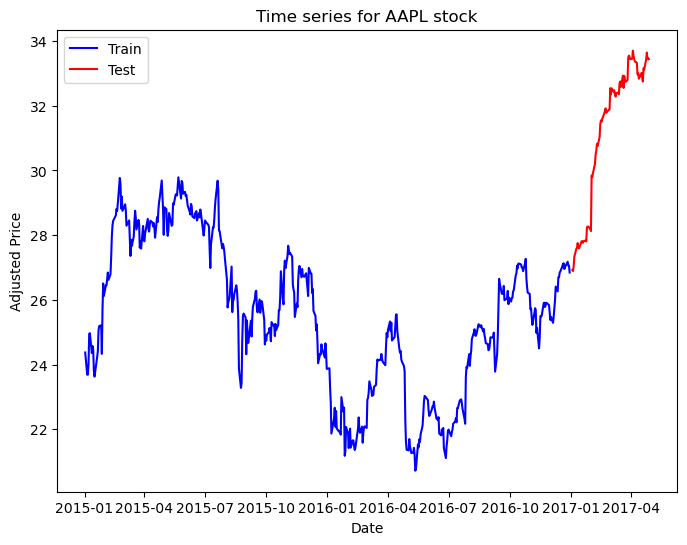

In [27]:
plt.plot(df_Apple_train_p['Date'],df_Apple_train_p['Adj Close'],color='blue',label='Train')
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],color='red',label='Test')
plt.xlabel('Date')
plt.ylabel('Adjusted Price')
plt.title('Time series for AAPL stock')
plt.legend()
plt.show()

In order to train the Neural Network, we should scale the data. We use the auxiliary function `data_process_array` to do so.

In [28]:
scaled_array_train_p, scaled_array_test_p=data_process_array(df_Apple_train_p,df_Apple_test_p)

For sanity check, let us plot both training and test data

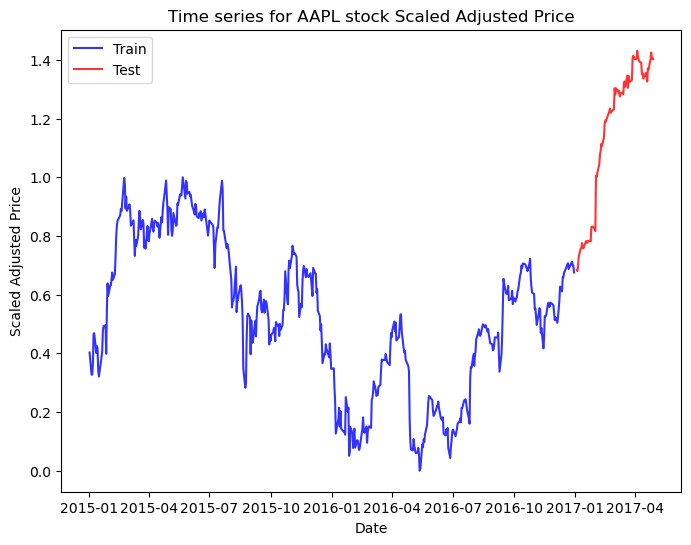

In [131]:
plt.plot(df_Apple_train_p['Date'],scaled_array_train_p[:,0],alpha=0.8,color='blue',label='Train')
plt.plot(df_Apple_test_p['Date'],scaled_array_test_p[:,0],alpha=0.8,color='red',label='Test')
plt.xlabel('Date')
plt.ylabel('Scaled Adjusted Price')
plt.title('Time series for AAPL stock Scaled Adjusted Price')
plt.legend()
plt.show()

It is useful to join both train and test in one DataFrame, in particular for forecasting with a ronlling window.

In [30]:
condition_joined=(df_top_30['Date']>'2015-01-01')&(df_top_30['Date']<'2017-04-30')
df_top_30_joined=df_top_30[condition_joined]
df_Apple_joined_p=df_top_30_joined[df_top_30_joined['Symbol']=='AAPL'][['Date','Adj Close']].reset_index()
df_Apple_joined_p.drop('index', axis=1, inplace=True)

Next, we want to generate rolling window interval training points.

In order to explain the rolling window input, consider this example of rolling window of size $5$.

Suppose a time series of interest is $[ a_1,a_2, a_3, a_4, a_5, a_6, a_7, a_8]$.

__Step 1:__

- rolling window:$X_1=[ a_1,a_2, a_3, a_4, a_5]$, 

- target is $y_1=[a_6]$.


__Step 2:__

- rolling window:$X_2=[ a_2, a_3, a_4, a_5,a_6]$, 

- Target is $y_2=[a_7]$.



__Step 3:__

- rolling window:$X_3=[ a_3, a_4, a_5, a_6, a_7]$, 

- Target is $y_3=[a_8]$.


Therefore, the feature input would be the $X_{\text{input}} = (X_1,X_2,X_3) $ and the target would be $y_{\text{input}} = (y_1,y_2,y_3)$. 
The auxiliary function `rolling_window_time_series` adds one more dimension in order to be ready for a Keras training.


 We will work with __40 past data points__, and the auxiliary function
`rolling_window_time_series` will divide the training and test time series accordingly.

In [31]:
X_train_p,y_train_p=rolling_window_time_series(scaled_array_train_p,40)
X_test_p,y_test_p=rolling_window_time_series(scaled_array_test_p,40)

In [32]:
# Let us print the shape of the objects. X_train should be (n_input-window,window,1)
print("X_train :",X_train_p.shape,"y_train :",y_train_p.shape)
print("X_test :",X_test_p.shape,"y_test :",y_test_p.shape)

X_train : (464, 40, 1) y_train : (464, 1)
X_test : (41, 40, 1) y_test : (41, 1)


In [33]:
scaled_joined_p=np.concatenate((scaled_array_train_p, scaled_array_test_p), axis=0)

In [34]:
X_joined_p,y_joined=rolling_window_time_series(scaled_joined_p,40)

In [35]:
list_dates_joined=df_Apple_joined_p['Date'].iloc[40:].tolist()

Whenever we are going to predict, we want to avoid data leakage. Therefore, instead of getting the whole test data range and using the Scaler, as implicitly we would tell the model about future minimum and maximum point.

Our approach is that for forecasting, we use the Scaler for the window itself, and not the whole test data range.

We can use the auxiliary functions we wrote in auxiliary_functions, `data_process_array_SL` and `rolling_window_Scale_Transform_SL`.

In [51]:
X_forecast,X_forecast_scaled=data_process_array_SL(df_Apple_joined_p,40)

I want to use the `ModelCheckpoint` in order to save the model every 10 epochs, which might be useful in case we train for a longer period of time. The documentation is that it uses save_freq, which is a function of the sample size and batches.

For instance, we have (we will use $\text{batches\_size}=2$ in the following codes)

$ \text{batches\_per\_epoch} = \frac{\text{total\_samples}}{\text{batches\_size}} = \frac{464}{2} = 232$.

Now we can simply calculate the frequency of saving with regards to the epoch. If I want to save my model after 10 epochs, we have

$\text{save\_freq} = 10 \, \times \, \text{batches\_per\_epoch} = 2320$.

We include this calculation inside the auxiliary function to train the Neural Network.



### TensorBoard

For this data size and task, saving each run on tesnorboard is not a necessary step, but we still included it for completeness.

In [36]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

We are ready to start out forecasting analysis!

## Part 9 - Summary and comparing the best 3 models for RNN, GRU and LSTM

In this section, we compare the main findings from our experiments with Neural Network architectures. The interested reader should check out the experiments in __Appendices C-E__ to understand how the hyperparameters were selected: for ease of presentation, in this section we only investigate one architecture for RNN, one for GRU and one for LSTM. 

We can fit a neural network with the best hyperparameters by calling the auxiliary functions
`neural_network_run_RNN`, `neural_network_run_GRU` and `neural_network_run_LSTM`. 

Let us look into the documentation of one of them (the inputs are the same for the 3 functions):

In [37]:
print(neural_network_run_RNN.__doc__)


    The function to train and fit neural networks! Created the base example the architecture that was mostly successful 
    for all architectures, but still put enough of hyperparameters as optional inputs so we can experiment with them. 

    Use simple Recurrent Neural Network as architecture!

    Input:
    ------
    X_train: Shape (n_input-window,window,1), the training data for the neural network.

    y_train: Shape (n_input-window,1), the value at window+1 used as a target for training.

    experiment: String describing the experiment, useful for labeling the logs. For instance, for a hidden_states experiment, call
    the f-string f'hiddenlayers_{hidden_states}'

    hidden_states: We fix the architecture as 40-hidden_states-40-1, default is hidden_states=80.

    activation: Activation function for the 40-hidden_states-40 layers, default is ReLU.

    dropout: Dropout of nodes, useful to control overfitting when it is important. Default is dropout=0.05.

    flag_optimize

If we do not need to test hyperparameters, we cna only pass three values: input training data `X_train`, input training target data `y_train` and a string `experiment`, that labels the warnings and the checkpoints and Tensorboard objects. 

We can therefore fit RNN, GRU and LSTM to our data.

In [38]:
# Simple RNN

experiment='final'
    
model_RNN, model_RNN_history=neural_network_run_RNN(X_train_p, y_train_p, experiment)

# Save the model
model_RNN.save('RNN_opt_Adam.h5')



Working on experiment final


2024-12-12 13:03:24.569493: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [39]:
# GRU
    
experiment='final'
    
model_GRU, model_GRU_history=neural_network_run_GRU(X_train_p, y_train_p, experiment)

# Save the model
model_GRU.save('GRU_opt_Adam.h5')





Working on experiment final


In [40]:
#LSTM


experiment='final'
    

    
model_LSTM, model_LSTM_history=neural_network_run_LSTM(X_train_p, y_train_p, experiment,optimizer='RMSprop')


# Save the model
model_LSTM.save('LSTM_opt_RMSprop.h5')






Working on experiment final


Whenever we are going to predict, we want to avoid data leakage. Therefore, instead of getting the whole test data range and using the Scaler, as implicitly we would tell the model about future minimum and maximum point.

Our approach is that for forecasting, we use the Scaler for the window itself, and not the whole test data range.

We can use the auxiliary functions we wrote in auxiliary_functions, `data_process_array_SL` and `rolling_window_Scale_Transform_SL`.

In [52]:
y_RNN_predict = model_RNN.predict(X_forecast_scaled,verbose=0)
y_GRU_predict = model_GRU.predict(X_forecast_scaled,verbose=0)
y_LSTM_predict = model_LSTM.predict(X_forecast_scaled,verbose=0)

Put them in a DataFrame

In [53]:
df_y_RNN_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict[:,0]})
df_y_GRU_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict[:,0]})
df_y_LSTM_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict[:,0]})

If we want to calculate MSE for the test data, we need to restrict to predictions in the test date range. Therefore, we create arrays with `_predict` subscript.

In [54]:
scaled_array_test_RNN_predict=df_y_RNN_predict[df_y_RNN_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values
scaled_array_test_GRU_predict=df_y_GRU_predict[df_y_GRU_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values
scaled_array_test_LSTM_predict=df_y_LSTM_predict[df_y_LSTM_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

Of course the neural network gives predictions scaled with the MinMax over the training data. We use the auxiliary function `rolling_window_Scale_Transform_SL` to scale back to the original prices.

In [55]:
y_RNN_predict_unscaled=rolling_window_Scale_Transform_SL(X_forecast,y_RNN_predict)
y_GRU_predict_unscaled=rolling_window_Scale_Transform_SL(X_forecast,y_GRU_predict)
y_LSTM_predict_unscaled=rolling_window_Scale_Transform_SL(X_forecast,y_LSTM_predict)

Let us create DataFrames with the unscaled predictions.

In [56]:
df_y_RNN_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict_unscaled[:,0]})
df_y_RNN_predict_unscaled_plot=df_y_RNN_predict_unscaled[df_y_RNN_predict_unscaled['Date'].isin(df_Apple_test_p['Date'])]

df_y_GRU_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict_unscaled[:,0]})
df_y_GRU_predict_unscaled_plot=df_y_GRU_predict_unscaled[df_y_GRU_predict_unscaled['Date'].isin(df_Apple_test_p['Date'])]

df_y_LSTM_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict_unscaled[:,0]})
df_y_LSTM_predict_unscaled_plot=df_y_LSTM_predict_unscaled[df_y_LSTM_predict_unscaled['Date'].isin(df_Apple_test_p['Date'])]

Finally, we can calculate the MSE for test and training data. For training, we simply recover the loss from `model_history` output of our auxiliary function `neural_network_run_RNN` (analogous to GRU and LSTM).

For MSE in the test data range, we have created the necessary arrays of prediction above to compare to the data.



We need to scale back the predicted prices to the training data scale, in order to be comparable to the training MSE. 
We can use the function `data_process_array`.


In [68]:
# Train Loss
mse_train_RNN= model_RNN_history.history['loss'][-1]
mse_train_GRU=model_GRU_history.history['loss'][-1]
mse_train_LSTM=model_LSTM_history.history['loss'][-1]


# Test MSE

_, scaled_predict_RNN_MSE_test=data_process_array(df_Apple_train_p,df_y_RNN_predict_unscaled_plot)
_, scaled_predict_GRU_MSE_test=data_process_array(df_Apple_train_p,df_y_GRU_predict_unscaled_plot)
_, scaled_predict_LSTM_MSE_test=data_process_array(df_Apple_train_p,df_y_LSTM_predict_unscaled_plot)

mse_test_RNN=mse(scaled_array_test_p[:,0],scaled_predict_RNN_MSE_test[:,0]).numpy()
mse_test_GRU=mse(scaled_array_test_p[:,0],scaled_predict_GRU_MSE_test[:,0]).numpy()
mse_test_LSTM=mse(scaled_array_test_p[:,0],scaled_predict_LSTM_MSE_test[:,0]).numpy()

#### Plot 

For readibility, we are plotting only in the test data range for now (so the model was __not__ trained on these prices). 

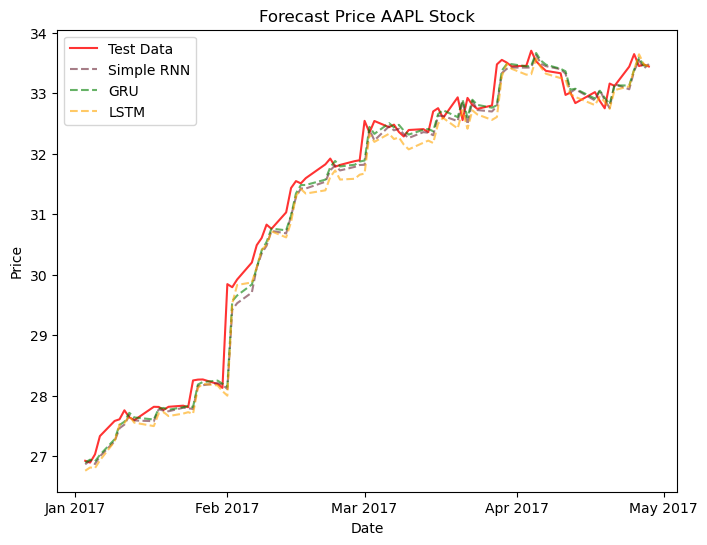

In [69]:
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test Data')
plt.plot(df_y_RNN_predict_unscaled_plot['Date'],df_y_RNN_predict_unscaled_plot['Adj Close'],color='#6b2737',alpha=0.6,label='Simple RNN',linestyle='dashed')
plt.plot(df_y_GRU_predict_unscaled_plot['Date'],df_y_GRU_predict_unscaled_plot['Adj Close'],color='g',alpha=0.6,label='GRU',linestyle='dashed')
plt.plot(df_y_LSTM_predict_unscaled_plot['Date'],df_y_LSTM_predict_unscaled_plot['Adj Close'],color='orange',alpha=0.6,label='LSTM',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Forecast Price AAPL Stock')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
plt.savefig('figures/forecast/price_comparison.png')
plt.show()

We see that the predictions __follow the trend__ of the prices to a good agreement! Even though MSE could indeed get slightly better, possibly with more investigation of hyperparameters, these models seem to be successfully capturing some of the structure of future prices. Important to remind the reader that the model was __not__ trained on this data. 

One interesting future exploration is to try to understand to which extent the NN are indeed capturing the overall trend of the market. We will see in Appendix A that ARIMA models can have smaller MSE, but it does seem to oscillate more heavily around the real data. 

For completeness, let us also plot the predictions from the NN during training and testing

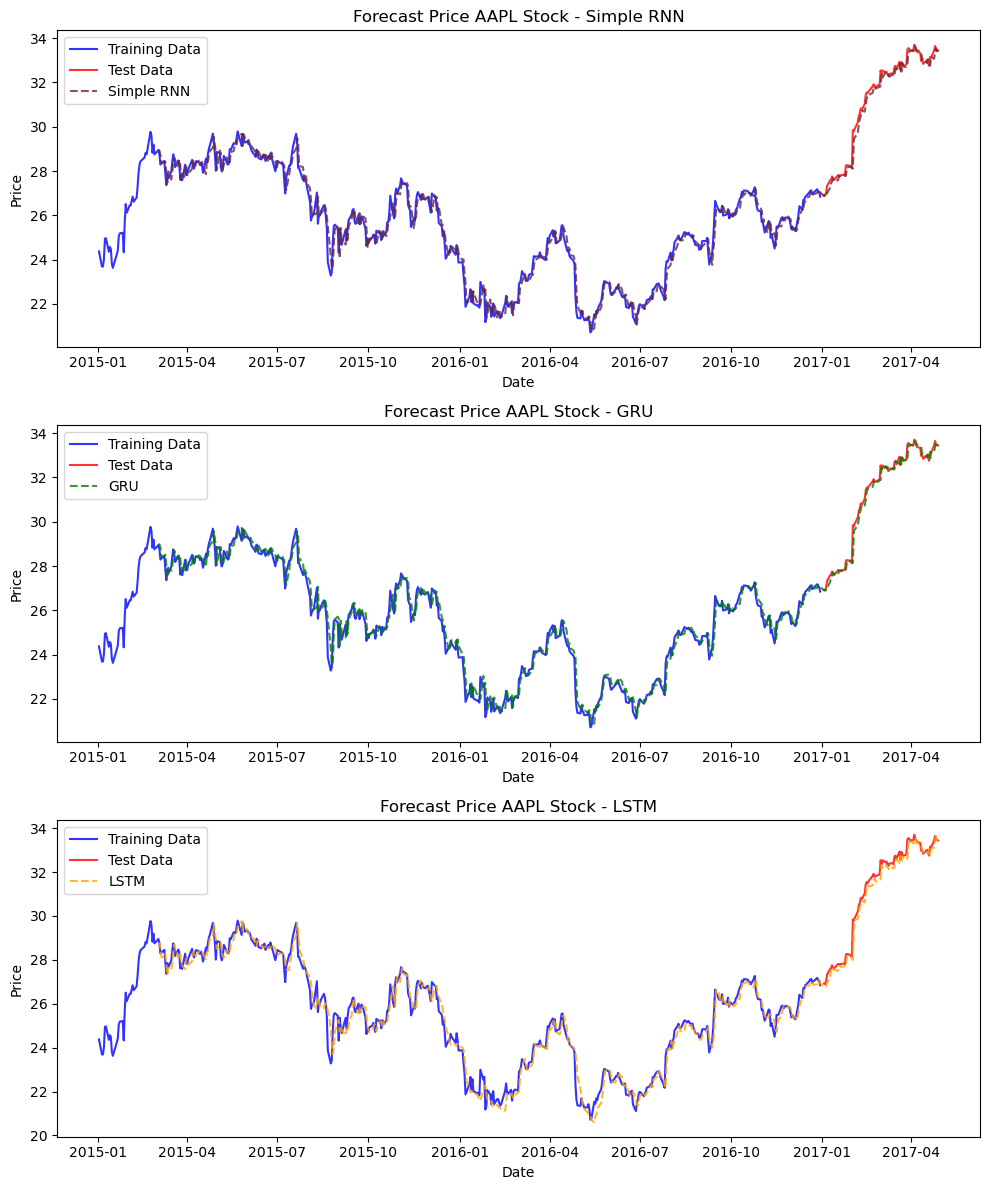

In [70]:

plt.subplots(3, 1, figsize=(10, 12))


plt.subplot(3,1,1)
plt.plot(df_Apple_train_p['Date'],df_Apple_train_p['Adj Close'],alpha=0.8,color='blue',label='Training Data')
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test Data')
plt.plot(df_y_RNN_predict_unscaled['Date'],df_y_RNN_predict_unscaled['Adj Close'],alpha=0.8,color='#6b2737',linestyle='dashed',label='Simple RNN')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Forecast Price AAPL Stock - Simple RNN')
plt.legend()


plt.subplot(3,1,2)
plt.plot(df_Apple_train_p['Date'],df_Apple_train_p['Adj Close'],alpha=0.8,color='blue',label='Training Data')
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test Data')
plt.plot(df_y_GRU_predict_unscaled['Date'],df_y_GRU_predict_unscaled['Adj Close'],alpha=0.8,color='green',linestyle='dashed',label='GRU')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Forecast Price AAPL Stock - GRU')
plt.legend()


plt.subplot(3,1,3)
plt.plot(df_Apple_train_p['Date'],df_Apple_train_p['Adj Close'],alpha=0.8,color='blue',label='Training Data')
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test Data')
plt.plot(df_y_LSTM_predict_unscaled['Date'],df_y_LSTM_predict_unscaled['Adj Close'],alpha=0.8,color='orange',linestyle='dashed',label='LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Forecast Price AAPL Stock - LSTM')
plt.legend()



plt.tight_layout()
plt.savefig('figures/forecast/price_fullrange.png')


plt.show()



In [71]:
print(f'RNN: MSE Train (loss): {mse_train_RNN:.4f}')
print(f'RNN: MSE Test: {mse_test_RNN:.4f}')
print('')
print(f'GRU: MSE Train (loss): {mse_train_GRU:.4f}')
print(f'GRU: MSE Test: {mse_test_GRU:.4f}')
print('')
print(f'LSTM: MSE Train (loss): {mse_train_LSTM:.4f}')
print(f'LSTM: MSE Test: {mse_test_LSTM:.4f}')

RNN: MSE Train (loss): 0.0029
RNN: MSE Test: 0.0012

GRU: MSE Train (loss): 0.0029
GRU: MSE Test: 0.0010

LSTM: MSE Train (loss): 0.0035
LSTM: MSE Test: 0.0014


Similar MSE between the 3 models, but for this architecture GRU did the best. Also as we noted, MSE is __not__ the only important metric to determine whether the model was more successful or not, if anything it should only be an indicator. And at least as an indicator, it seems our models were successful in forecasting price and capturing the trend of the market.

## Part 10 - Neural Network Examples with Different Stock Indices

Let us briefly comment and test using the same trained networks for different stocks around the same time period. We will __not__ retrain the neural networks for these stocks; we will just test whether the ones trained for `Apple` should  be enough. We will forecast for three different Stocks: `Walmart`, `JP Morgan` and `Chevron` for the year 2018-2019.


We wrote this section with a more python script spirit, to be easy to transfer it to a StremLit app for instance.

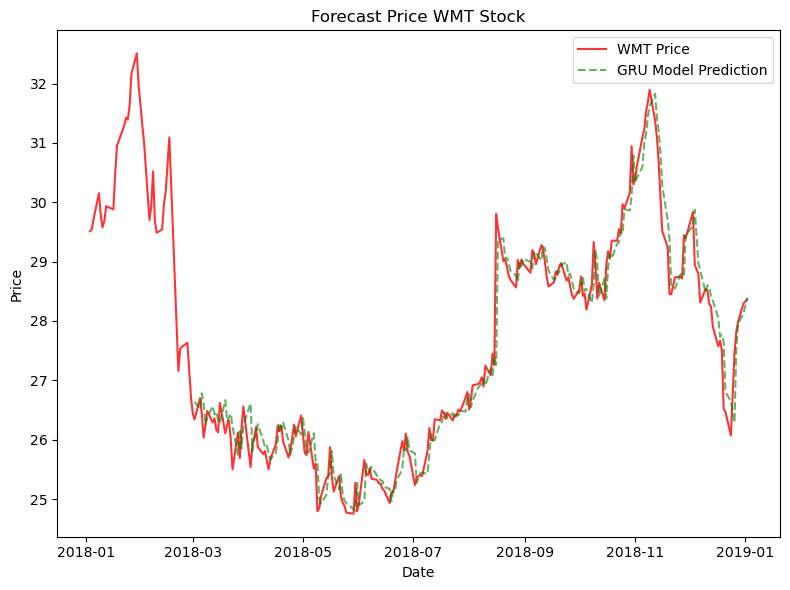

In [113]:
# Assume this is the user input

input_date_start='2018-01-02'
input_date_end='2019-01-02'
input_stock='WMT'


#Get the data

df_top_100=pd.read_csv('data/sp500_stocks_top_100.csv')
df_top_100['Date']=pd.to_datetime(df_top_100['Date'])

# Get the data the model was trained on. If putting a script, we have that as a separate .csv file. This is why we exported the train df.
df_OG_Training=pd.read_csv('Original_NN_Scaling.csv')
df_OG_Training['Date']=pd.to_datetime(df_OG_Training['Date'])


#Find only the dates within the interval
condition_date_interval=(df_top_100['Date']>input_date_start)&(df_top_100['Date']<=input_date_end)
df_top_100_interval=df_top_100[condition_date_interval]


# Focus only on the stock the user input

df_input_stock=df_top_100_interval[df_top_100_interval['Symbol']==input_stock][['Date','Adj Close']].reset_index()
df_input_stock.drop('index', axis=1, inplace=True)


# Scale only between 0 and 1 for the rolling window interval, as in principle we don't have data about the future. Return both
# scaled and unscaled.

X_long_unscaled,X_long_scaled =data_process_array_SL(df_input_stock,40)

# List of data for the prediction
list_dates_joined=df_input_stock['Date'].iloc[40:].tolist()

# Load the trained Neural Network, GRU had the best performance
model_RNN = load_model('RNN_opt_Adam.h5')
model_GRU = load_model('GRU_opt_Adam.h5')
model_LSTM = load_model('LSTM_opt_RMSprop.h5')



# Predict

y_RNN_predict = model_RNN.predict(X_long_scaled,verbose=0)
y_GRU_predict = model_GRU.predict(X_long_scaled,verbose=0)
y_LSTM_predict = model_LSTM.predict(X_long_scaled,verbose=0)


# Put into a DataFrame

df_y_RNN_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict[:,0]})
df_y_GRU_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict[:,0]})
df_y_LSTM_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict[:,0]})

# We also need the scaled back price

y_RNN_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_RNN_predict)
y_GRU_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_GRU_predict)
y_LSTM_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_LSTM_predict)


#  Create DataFrame
df_y_RNN_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict_unscaled[:,0]})
df_y_RNN_predict_unscaled_plot=df_y_RNN_predict_unscaled[df_y_RNN_predict_unscaled['Date'].isin(df_input_stock['Date'])]

df_y_GRU_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict_unscaled[:,0]})
df_y_GRU_predict_unscaled_plot=df_y_GRU_predict_unscaled[df_y_GRU_predict_unscaled['Date'].isin(df_input_stock['Date'])]

df_y_LSTM_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict_unscaled[:,0]})
df_y_LSTM_predict_unscaled_plot=df_y_LSTM_predict_unscaled[df_y_LSTM_predict_unscaled['Date'].isin(df_input_stock['Date'])]


plt.plot(df_input_stock['Date'],df_input_stock['Adj Close'],alpha=0.8,color='red',label=f'{input_stock} Price')
plt.plot(df_y_GRU_predict_unscaled_plot['Date'],df_y_GRU_predict_unscaled_plot['Adj Close'],color='g',alpha=0.6,label='GRU Model Prediction',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Forecast Price {input_stock} Stock')
plt.legend()
plt.tight_layout()
plt.show()


Of course we can also plot the other architectures

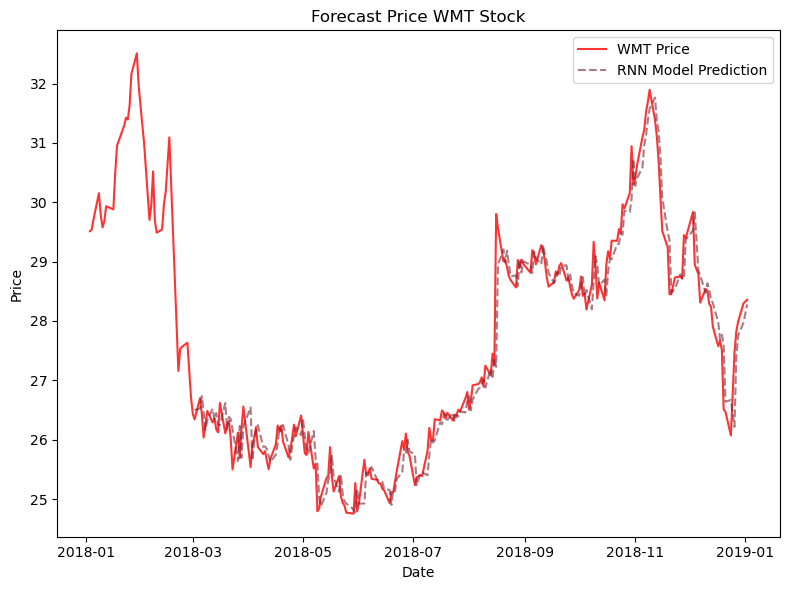

In [92]:
plt.plot(df_input_stock['Date'],df_input_stock['Adj Close'],alpha=0.8,color='red',label=f'{input_stock} Price')
plt.plot(df_y_RNN_predict_unscaled_plot['Date'],df_y_RNN_predict_unscaled_plot['Adj Close'],color='#6b2737',alpha=0.6,label='RNN Model Prediction',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Forecast Price {input_stock} Stock')
plt.legend()
plt.tight_layout()
plt.show()


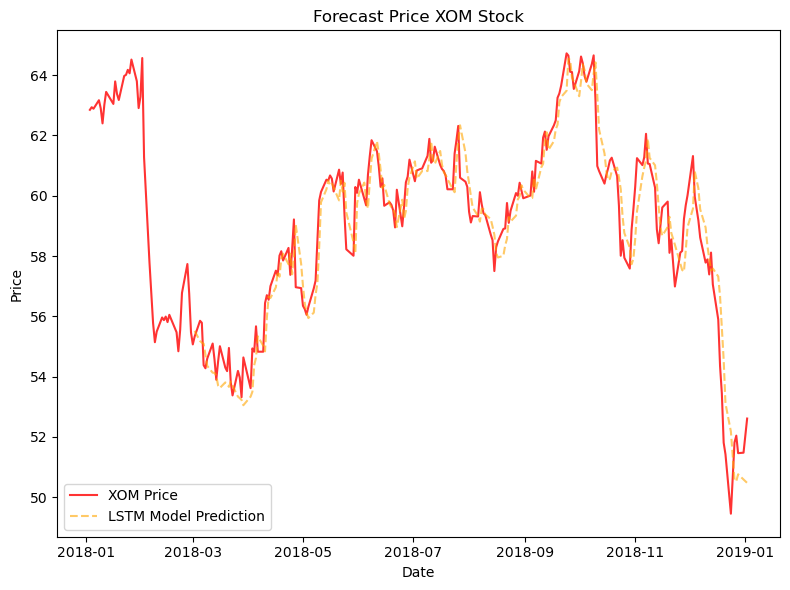

In [80]:
plt.plot(df_input_stock['Date'],df_input_stock['Adj Close'],alpha=0.8,color='red',label=f'{input_stock} Price')
plt.plot(df_y_LSTM_predict_unscaled_plot['Date'],df_y_LSTM_predict_unscaled_plot['Adj Close'],color='orange',alpha=0.6,label='LSTM Model Prediction',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Forecast Price {input_stock} Stock')
plt.legend()
plt.tight_layout()
plt.show()


Finally, we can calculate the mse score as well. For instance, we would have

Transfer back to original training scale, in order to be more comparable. 
Caveat is that the scale of the problem itself is quite different depending on the stock price, so comparison to the
original MSE should be taken with a grain of salt. Also the data range considered is higher here than the one we tested in the previous section, which should also naturally increase the MSE.

Remember that MSE is given by $\text{MSE} = \frac{1}{n} \sum_{i=1}^n \left( y_{\text{true},i} - y_{\text{pred},i} \right)^2$, so if more points are added, there is a mismatch between the numerator and denominator as a function of n.


In [114]:
# Scale back the actual prices

_, scaled_array_test_new_p=data_process_array(df_OG_Training,df_input_stock.iloc[40:])

# Scale back the actual prices

_, scaled_predict_RNN_MSE_test=data_process_array(df_OG_Training,df_y_RNN_predict_unscaled_plot)
_, scaled_predict_GRU_MSE_test=data_process_array(df_OG_Training,df_y_GRU_predict_unscaled_plot)
_, scaled_predict_LSTM_MSE_test=data_process_array(df_OG_Training,df_y_LSTM_predict_unscaled_plot)

# Calculate MSE


mse_test_WMT_RNN=mse(scaled_array_test_new_p[:,0],scaled_predict_RNN_MSE_test[:,0]).numpy()
mse_test_WMT_GRU=mse(scaled_array_test_new_p[:,0],scaled_predict_GRU_MSE_test[:,0]).numpy()
mse_test_WMT_LSTM=mse(scaled_array_test_new_p[:,0],scaled_predict_LSTM_MSE_test[:,0]).numpy()

#### Walmart summary

In [117]:
print('Walmart summary:')
print('')
print(f'RNN: MSE Test: {mse_test_WMT_RNN:.4f}')
print('')
print(f'GRU: MSE Test: {mse_test_WMT_GRU:.4f}')
print('')
print(f'LSTM: MSE Test: {mse_test_WMT_LSTM:.4f}')

Walmart summary:

RNN: MSE Test: 0.0017

GRU: MSE Test: 0.0017

LSTM: MSE Test: 0.0022


We can also analyze other stocks as well! Another different industry with higher price scales, JP Morgan

#### JP Morgan

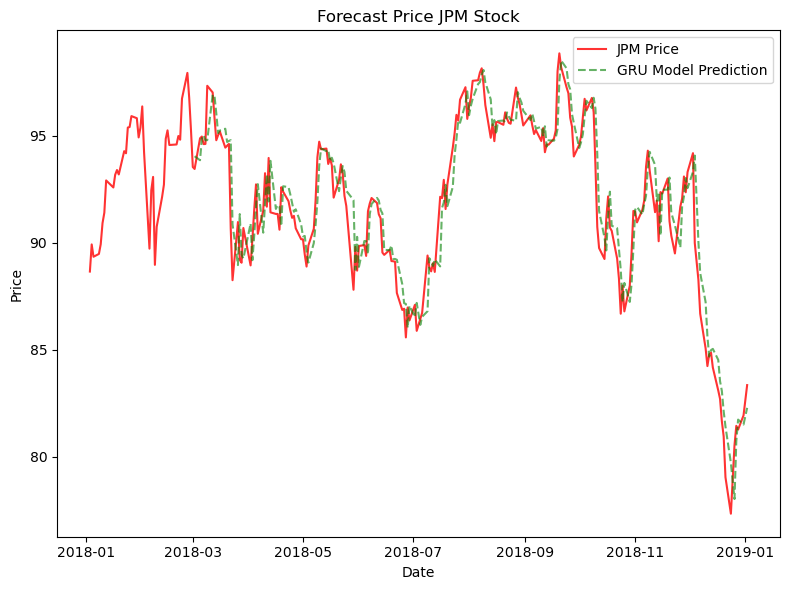

In [118]:
# Assume this is the user input

input_date_start='2018-01-02'
input_date_end='2019-01-02'
input_stock='JPM'


#Get the data

df_top_100=pd.read_csv('data/sp500_stocks_top_100.csv')
df_top_100['Date']=pd.to_datetime(df_top_100['Date'])

# Get the data the model was trained on. If putting a script, we have that as a separate .csv file. This is why we exported the train df.
df_OG_Training=pd.read_csv('Original_NN_Scaling.csv')
df_OG_Training['Date']=pd.to_datetime(df_OG_Training['Date'])


#Find only the dates within the interval
condition_date_interval=(df_top_100['Date']>input_date_start)&(df_top_100['Date']<=input_date_end)
df_top_100_interval=df_top_100[condition_date_interval]


# Focus only on the stock the user input

df_input_stock=df_top_100_interval[df_top_100_interval['Symbol']==input_stock][['Date','Adj Close']].reset_index()
df_input_stock.drop('index', axis=1, inplace=True)


# Scale only between 0 and 1 for the rolling window interval, as in principle we don't have data about the future. Return both
# scaled and unscaled.

X_long_unscaled,X_long_scaled =data_process_array_SL(df_input_stock,40)

# List of data for the prediction
list_dates_joined=df_input_stock['Date'].iloc[40:].tolist()

# Load the trained Neural Network, GRU had the best performance
model_RNN = load_model('RNN_opt_Adam.h5')
model_GRU = load_model('GRU_opt_Adam.h5')
model_LSTM = load_model('LSTM_opt_RMSprop.h5')



# Predict

y_RNN_predict = model_RNN.predict(X_long_scaled,verbose=0)
y_GRU_predict = model_GRU.predict(X_long_scaled,verbose=0)
y_LSTM_predict = model_LSTM.predict(X_long_scaled,verbose=0)


# Put into a DataFrame

df_y_RNN_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict[:,0]})
df_y_GRU_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict[:,0]})
df_y_LSTM_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict[:,0]})

# We also need the scaled back price

y_RNN_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_RNN_predict)
y_GRU_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_GRU_predict)
y_LSTM_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_LSTM_predict)


#  Create DataFrame
df_y_RNN_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict_unscaled[:,0]})
df_y_RNN_predict_unscaled_plot=df_y_RNN_predict_unscaled[df_y_RNN_predict_unscaled['Date'].isin(df_input_stock['Date'])]

df_y_GRU_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict_unscaled[:,0]})
df_y_GRU_predict_unscaled_plot=df_y_GRU_predict_unscaled[df_y_GRU_predict_unscaled['Date'].isin(df_input_stock['Date'])]

df_y_LSTM_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict_unscaled[:,0]})
df_y_LSTM_predict_unscaled_plot=df_y_LSTM_predict_unscaled[df_y_LSTM_predict_unscaled['Date'].isin(df_input_stock['Date'])]


plt.plot(df_input_stock['Date'],df_input_stock['Adj Close'],alpha=0.8,color='red',label=f'{input_stock} Price')
plt.plot(df_y_GRU_predict_unscaled_plot['Date'],df_y_GRU_predict_unscaled_plot['Adj Close'],color='g',alpha=0.6,label='GRU Model Prediction',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Forecast Price {input_stock} Stock')
plt.legend()
plt.tight_layout()
plt.show()


In [119]:
# Scale back the actual prices

_, scaled_array_test_new_p=data_process_array(df_OG_Training,df_input_stock.iloc[40:])

# Scale back the actual prices

_, scaled_predict_RNN_MSE_test=data_process_array(df_OG_Training,df_y_RNN_predict_unscaled_plot)
_, scaled_predict_GRU_MSE_test=data_process_array(df_OG_Training,df_y_GRU_predict_unscaled_plot)
_, scaled_predict_LSTM_MSE_test=data_process_array(df_OG_Training,df_y_LSTM_predict_unscaled_plot)

# Calculate MSE


mse_test_JPM_RNN=mse(scaled_array_test_new_p[:,0],scaled_predict_RNN_MSE_test[:,0]).numpy()
mse_test_JPM_GRU=mse(scaled_array_test_new_p[:,0],scaled_predict_GRU_MSE_test[:,0]).numpy()
mse_test_JPM_LSTM=mse(scaled_array_test_new_p[:,0],scaled_predict_LSTM_MSE_test[:,0]).numpy()

#### JP Morgan summary

In [120]:
print('JPM summary:')
print('')
print(f'RNN: MSE Test: {mse_test_JPM_RNN:.4f}')
print('')
print(f'GRU: MSE Test: {mse_test_JPM_GRU:.4f}')
print('')
print(f'LSTM: MSE Test: {mse_test_JPM_LSTM:.4f}')

JPM summary:

RNN: MSE Test: 0.0197

GRU: MSE Test: 0.0193

LSTM: MSE Test: 0.0277


Notice that the MSE is higher, but also the price is twice as big, so it could just be a matter of scaling between the problems.

#### Chevron

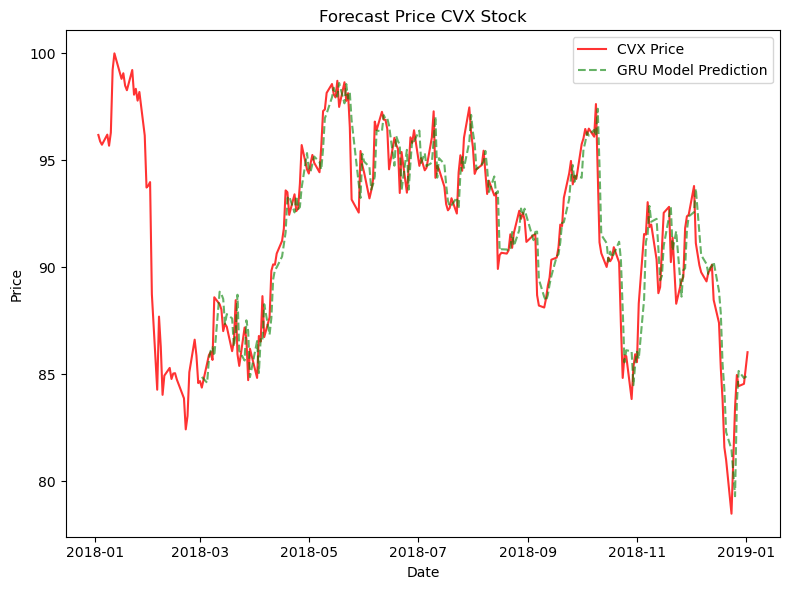

In [121]:
# Assume this is the user input

input_date_start='2018-01-02'
input_date_end='2019-01-02'
input_stock='CVX'


#Get the data

df_top_100=pd.read_csv('data/sp500_stocks_top_100.csv')
df_top_100['Date']=pd.to_datetime(df_top_100['Date'])

# Get the data the model was trained on. If putting a script, we have that as a separate .csv file. This is why we exported the train df.
df_OG_Training=pd.read_csv('Original_NN_Scaling.csv')
df_OG_Training['Date']=pd.to_datetime(df_OG_Training['Date'])


#Find only the dates within the interval
condition_date_interval=(df_top_100['Date']>input_date_start)&(df_top_100['Date']<=input_date_end)
df_top_100_interval=df_top_100[condition_date_interval]


# Focus only on the stock the user input

df_input_stock=df_top_100_interval[df_top_100_interval['Symbol']==input_stock][['Date','Adj Close']].reset_index()
df_input_stock.drop('index', axis=1, inplace=True)


# Scale only between 0 and 1 for the rolling window interval, as in principle we don't have data about the future. Return both
# scaled and unscaled.

X_long_unscaled,X_long_scaled =data_process_array_SL(df_input_stock,40)

# List of data for the prediction
list_dates_joined=df_input_stock['Date'].iloc[40:].tolist()

# Load the trained Neural Network, GRU had the best performance
model_RNN = load_model('RNN_opt_Adam.h5')
model_GRU = load_model('GRU_opt_Adam.h5')
model_LSTM = load_model('LSTM_opt_RMSprop.h5')



# Predict

y_RNN_predict = model_RNN.predict(X_long_scaled,verbose=0)
y_GRU_predict = model_GRU.predict(X_long_scaled,verbose=0)
y_LSTM_predict = model_LSTM.predict(X_long_scaled,verbose=0)


# Put into a DataFrame

df_y_RNN_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict[:,0]})
df_y_GRU_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict[:,0]})
df_y_LSTM_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict[:,0]})

# We also need the scaled back price

y_RNN_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_RNN_predict)
y_GRU_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_GRU_predict)
y_LSTM_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_LSTM_predict)


#  Create DataFrame
df_y_RNN_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict_unscaled[:,0]})
df_y_RNN_predict_unscaled_plot=df_y_RNN_predict_unscaled[df_y_RNN_predict_unscaled['Date'].isin(df_input_stock['Date'])]

df_y_GRU_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict_unscaled[:,0]})
df_y_GRU_predict_unscaled_plot=df_y_GRU_predict_unscaled[df_y_GRU_predict_unscaled['Date'].isin(df_input_stock['Date'])]

df_y_LSTM_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict_unscaled[:,0]})
df_y_LSTM_predict_unscaled_plot=df_y_LSTM_predict_unscaled[df_y_LSTM_predict_unscaled['Date'].isin(df_input_stock['Date'])]


plt.plot(df_input_stock['Date'],df_input_stock['Adj Close'],alpha=0.8,color='red',label=f'{input_stock} Price')
plt.plot(df_y_GRU_predict_unscaled_plot['Date'],df_y_GRU_predict_unscaled_plot['Adj Close'],color='g',alpha=0.6,label='GRU Model Prediction',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Forecast Price {input_stock} Stock')
plt.legend()
plt.tight_layout()
plt.show()


In [122]:
# Scale back the actual prices

_, scaled_array_test_new_p=data_process_array(df_OG_Training,df_input_stock.iloc[40:])

# Scale back the actual prices

_, scaled_predict_RNN_MSE_test=data_process_array(df_OG_Training,df_y_RNN_predict_unscaled_plot)
_, scaled_predict_GRU_MSE_test=data_process_array(df_OG_Training,df_y_GRU_predict_unscaled_plot)
_, scaled_predict_LSTM_MSE_test=data_process_array(df_OG_Training,df_y_LSTM_predict_unscaled_plot)

# Calculate MSE


mse_test_CVX_RNN=mse(scaled_array_test_new_p[:,0],scaled_predict_RNN_MSE_test[:,0]).numpy()
mse_test_CVX_GRU=mse(scaled_array_test_new_p[:,0],scaled_predict_GRU_MSE_test[:,0]).numpy()
mse_test_CVX_LSTM=mse(scaled_array_test_new_p[:,0],scaled_predict_LSTM_MSE_test[:,0]).numpy()

#### Chevron summary

In [123]:
print('CVX summary:')
print('')
print(f'RNN: MSE Test: {mse_test_CVX_RNN:.4f}')
print('')
print(f'GRU: MSE Test: {mse_test_CVX_GRU:.4f}')
print('')
print(f'LSTM: MSE Test: {mse_test_CVX_LSTM:.4f}')

CVX summary:

RNN: MSE Test: 0.0220

GRU: MSE Test: 0.0217

LSTM: MSE Test: 0.0290


Similarly to JP morgan, the MSE is slightly higher also due to the scale of the problem.

#### Apple

#### Let us repeat the analysis for Apple in the same data range.

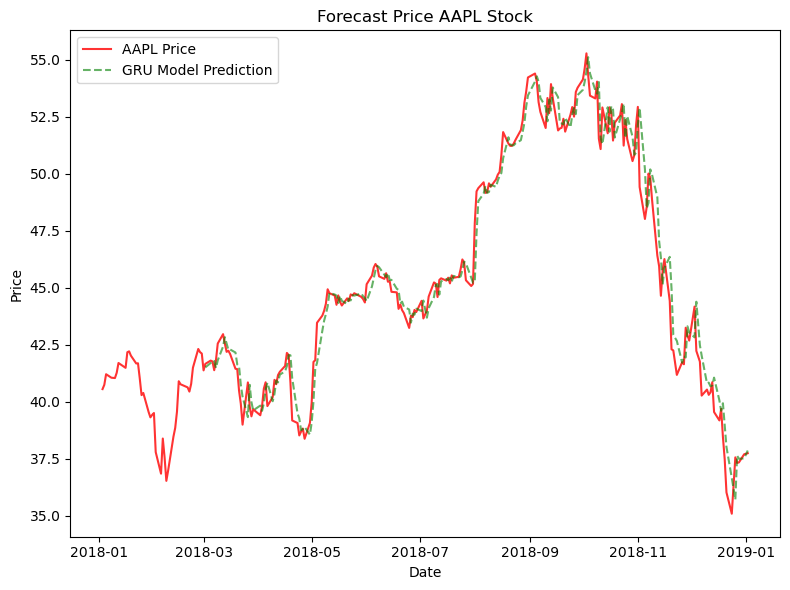

In [124]:
# Assume this is the user input

input_date_start='2018-01-02'
input_date_end='2019-01-02'
input_stock='AAPL'


#Get the data

df_top_100=pd.read_csv('data/sp500_stocks_top_100.csv')
df_top_100['Date']=pd.to_datetime(df_top_100['Date'])

# Get the data the model was trained on. If putting a script, we have that as a separate .csv file. This is why we exported the train df.
df_OG_Training=pd.read_csv('Original_NN_Scaling.csv')
df_OG_Training['Date']=pd.to_datetime(df_OG_Training['Date'])


#Find only the dates within the interval
condition_date_interval=(df_top_100['Date']>input_date_start)&(df_top_100['Date']<=input_date_end)
df_top_100_interval=df_top_100[condition_date_interval]


# Focus only on the stock the user input

df_input_stock=df_top_100_interval[df_top_100_interval['Symbol']==input_stock][['Date','Adj Close']].reset_index()
df_input_stock.drop('index', axis=1, inplace=True)


# Scale only between 0 and 1 for the rolling window interval, as in principle we don't have data about the future. Return both
# scaled and unscaled.

X_long_unscaled,X_long_scaled =data_process_array_SL(df_input_stock,40)

# List of data for the prediction
list_dates_joined=df_input_stock['Date'].iloc[40:].tolist()

# Load the trained Neural Network, GRU had the best performance
model_RNN = load_model('RNN_opt_Adam.h5')
model_GRU = load_model('GRU_opt_Adam.h5')
model_LSTM = load_model('LSTM_opt_RMSprop.h5')



# Predict

y_RNN_predict = model_RNN.predict(X_long_scaled,verbose=0)
y_GRU_predict = model_GRU.predict(X_long_scaled,verbose=0)
y_LSTM_predict = model_LSTM.predict(X_long_scaled,verbose=0)


# Put into a DataFrame

df_y_RNN_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict[:,0]})
df_y_GRU_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict[:,0]})
df_y_LSTM_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict[:,0]})

# We also need the scaled back price

y_RNN_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_RNN_predict)
y_GRU_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_GRU_predict)
y_LSTM_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_LSTM_predict)


#  Create DataFrame
df_y_RNN_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict_unscaled[:,0]})
df_y_RNN_predict_unscaled_plot=df_y_RNN_predict_unscaled[df_y_RNN_predict_unscaled['Date'].isin(df_input_stock['Date'])]

df_y_GRU_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict_unscaled[:,0]})
df_y_GRU_predict_unscaled_plot=df_y_GRU_predict_unscaled[df_y_GRU_predict_unscaled['Date'].isin(df_input_stock['Date'])]

df_y_LSTM_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict_unscaled[:,0]})
df_y_LSTM_predict_unscaled_plot=df_y_LSTM_predict_unscaled[df_y_LSTM_predict_unscaled['Date'].isin(df_input_stock['Date'])]


plt.plot(df_input_stock['Date'],df_input_stock['Adj Close'],alpha=0.8,color='red',label=f'{input_stock} Price')
plt.plot(df_y_GRU_predict_unscaled_plot['Date'],df_y_GRU_predict_unscaled_plot['Adj Close'],color='g',alpha=0.6,label='GRU Model Prediction',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Forecast Price {input_stock} Stock')
plt.legend()
plt.tight_layout()
plt.show()


In [125]:
# Scale back the actual prices

_, scaled_array_test_new_p=data_process_array(df_OG_Training,df_input_stock.iloc[40:])

# Scale back the actual prices

_, scaled_predict_RNN_MSE_test=data_process_array(df_OG_Training,df_y_RNN_predict_unscaled_plot)
_, scaled_predict_GRU_MSE_test=data_process_array(df_OG_Training,df_y_GRU_predict_unscaled_plot)
_, scaled_predict_LSTM_MSE_test=data_process_array(df_OG_Training,df_y_LSTM_predict_unscaled_plot)

# Calculate MSE


mse_test_AAPL_RNN=mse(scaled_array_test_new_p[:,0],scaled_predict_RNN_MSE_test[:,0]).numpy()
mse_test_AAPL_GRU=mse(scaled_array_test_new_p[:,0],scaled_predict_GRU_MSE_test[:,0]).numpy()
mse_test_AAPL_LSTM=mse(scaled_array_test_new_p[:,0],scaled_predict_LSTM_MSE_test[:,0]).numpy()

#### Apple summary

In [127]:
print('AAPL summary:')
print('')
print(f'RNN: MSE Test: {mse_test_CVX_RNN:.4f}')
print('')
print(f'GRU: MSE Test: {mse_test_CVX_GRU:.4f}')
print('')
print(f'LSTM: MSE Test: {mse_test_CVX_LSTM:.4f}')

AAPL summary:

RNN: MSE Test: 0.0220

GRU: MSE Test: 0.0217

LSTM: MSE Test: 0.0290


Interestingly, the model perfomed even a bit better in the other stocks! But we repeat, MSE is scale dependent and __NOT__ the only metric one should use in order to determine how accurate a model is. 

#### Summary of findings

- __Test, Forecasting into the future (2018-2019)__

|           | Simple RNN, MSE test        | GRU , MSE test        | LSTM, MSE test        |
|:----------|:---------------------------:|:---------------------:|:---------------------:|   
| Apple     |         0.022               |         0.022         |         0.029         |
| Walmart   |         0.0017              |         0.0017        |         0.0022        |
| JP Morgan |         0.020               |         0.020         |         0.028         |
| Chevron   |         0.022               |         0.022         |           0.029       |



It seems we were mostly successful in reproducing the prices for different stocks, even though we did __not retrain__ our networks! In fact, we achieved smaller MSE for some stocks than we did for Apple.

With more time and resource, hyperparameter cross validation is an important step to perform accross many different stocks, sices of window, training data size. But at least for a learning exercise and a proof of concept, it seems that the Neural Network architectures were successful in capturing the price trend. 

## Appendix A - Comparison with ARIMA

We want to compare our forecasting with Neural Network with other statistical model, sucha as ARIMA. The logic of training versus predicting is a bit different in this case: In the neural network, once we were done with optimizing the network with the training data, we did not need to retrain (of course we could do that for more precise models, but this is not the approach we took).

Since we used a rolling window of size $40$, we will fit an ARIMA model every $40$ steps, predicting and recording the next element every time.


For clarity, suppose we were to do a rolling window of size $5$, with a time series given by $[ a_1,a_2, a_3, a_4, a_5, a_6, a_7, a_8]$.

__Step 1:__

rolling window:$[ a_1,a_2, a_3, a_4, a_5]$, 

fit ARIMA(p,d,q) for $[ a_1,a_2, a_3, a_4, a_5]$ with target $[a_6]$.

predict 1 point into the future, $b_1$

__Step 2:__

rolling window:$[ a_2, a_3, a_4, a_5,a_6]$, 

fit ARIMA(p,d,q) for $[a_2, a_3, a_4, a_5,a_6]$ with target $[a_7]$.

predict 1 point into the future, $b_2$


__Step 3:__

rolling window:$[ a_3, a_4, a_5, a_6, a_7]$, 

fit ARIMA(p,d,q) for $[  a_3, a_4, a_5, a_6, a_7]$ with target $[a_8]$.

predict 1 point into the future, $b_3$

The __final prediction__ would be a list $[b_1, b_2, b_3]$ (size $n_{\text{input}}-\text{window}=8-5=3$).


Therefore, the logic of training and forecasting is slightly different than with the Neural Network examples we analyzed in the previous sections, in fact, for more complicated models, it can be slow to retrain at every step. Nonetheless, this should be an interesting comparison with the previous analysis, and we will see the Neural Network architectures we studies outperforms ARIMA, even if ARIMA is technically "retraining" at every step. 



For this section, we will go back to the __Apple__ stock analysis. In addition, notice that for the price range under consideration, we have __not__ trained the neural network on.

Let us repeat the cell that predicts the `AAPL` stock in the range we are interested

2016-12-31')&(df_top_30['Date']<'2017-04-30')

In [235]:
df_Apple_joined_p[df_Apple_joined_p['Date']<'2016-12-31'].iloc[-40:].shape

(40, 2)

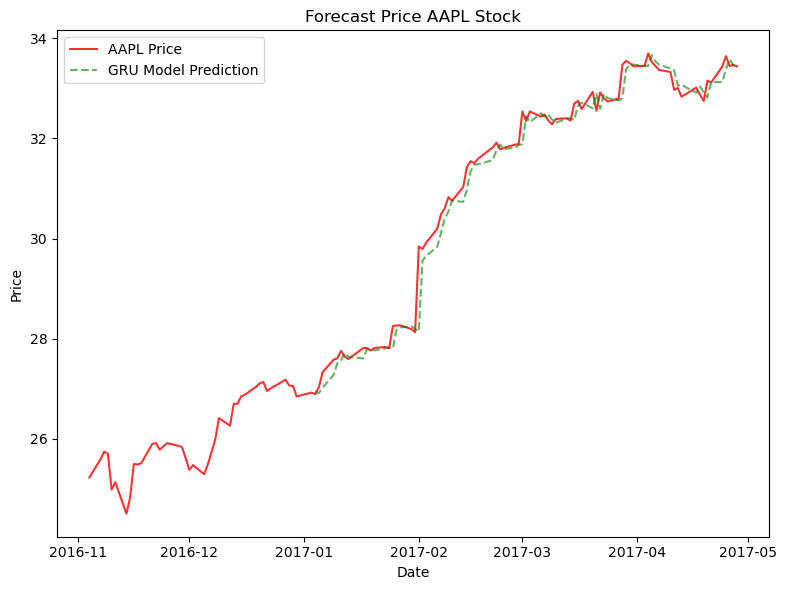

In [236]:
# Assume this is the user input

input_date_start='2016-11-03'
input_date_end='2017-04-30'
input_stock='AAPL'


#Get the data

df_top_100=pd.read_csv('data/sp500_stocks_top_100.csv')
df_top_100['Date']=pd.to_datetime(df_top_100['Date'])

# Get the data the model was trained on. If putting a script, we have that as a separate .csv file. This is why we exported the train df.
df_OG_Training=pd.read_csv('Original_NN_Scaling.csv')
df_OG_Training['Date']=pd.to_datetime(df_OG_Training['Date'])


#Find only the dates within the interval
condition_date_interval=(df_top_100['Date']>input_date_start)&(df_top_100['Date']<=input_date_end)
df_top_100_interval=df_top_100[condition_date_interval]


# Focus only on the stock the user input

df_input_stock=df_top_100_interval[df_top_100_interval['Symbol']==input_stock][['Date','Adj Close']].reset_index()
df_input_stock.drop('index', axis=1, inplace=True)


# Scale only between 0 and 1 for the rolling window interval, as in principle we don't have data about the future. Return both
# scaled and unscaled.

X_long_unscaled,X_long_scaled =data_process_array_SL(df_input_stock,40)

# List of data for the prediction
list_dates_joined=df_input_stock['Date'].iloc[40:].tolist()

# Load the trained Neural Network, GRU had the best performance
model_RNN = load_model('RNN_opt_Adam.h5')
model_GRU = load_model('GRU_opt_Adam.h5')
model_LSTM = load_model('LSTM_opt_RMSprop.h5')



# Predict

y_RNN_predict = model_RNN.predict(X_long_scaled,verbose=0)
y_GRU_predict = model_GRU.predict(X_long_scaled,verbose=0)
y_LSTM_predict = model_LSTM.predict(X_long_scaled,verbose=0)


# Put into a DataFrame

df_y_RNN_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict[:,0]})
df_y_GRU_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict[:,0]})
df_y_LSTM_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict[:,0]})

# We also need the scaled back price

y_RNN_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_RNN_predict)
y_GRU_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_GRU_predict)
y_LSTM_predict_unscaled=rolling_window_Scale_Transform_SL(X_long_unscaled,y_LSTM_predict)


#  Create DataFrame
df_y_RNN_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_RNN_predict_unscaled[:,0]})
df_y_RNN_predict_unscaled_plot=df_y_RNN_predict_unscaled[df_y_RNN_predict_unscaled['Date'].isin(df_input_stock['Date'])]

df_y_GRU_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_GRU_predict_unscaled[:,0]})
df_y_GRU_predict_unscaled_plot=df_y_GRU_predict_unscaled[df_y_GRU_predict_unscaled['Date'].isin(df_input_stock['Date'])]

df_y_LSTM_predict_unscaled=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_LSTM_predict_unscaled[:,0]})
df_y_LSTM_predict_unscaled_plot=df_y_LSTM_predict_unscaled[df_y_LSTM_predict_unscaled['Date'].isin(df_input_stock['Date'])]


plt.plot(df_input_stock['Date'],df_input_stock['Adj Close'],alpha=0.8,color='red',label=f'{input_stock} Price')
plt.plot(df_y_GRU_predict_unscaled_plot['Date'],df_y_GRU_predict_unscaled_plot['Adj Close'],color='g',alpha=0.6,label='GRU Model Prediction',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title(f'Forecast Price {input_stock} Stock')
plt.legend()
plt.tight_layout()
plt.show()


#### ARIMA (10,2,10)

We need to generate a rolling window for our data series. For the previous section, it was important to scale our original data in order to pass through the Neural Network. For ARIMA, since during this time period our data does not have a huge percentage difference between maximum and minimum, it should not influence the performance of ARIMA. 

Therefore, we will simply scale back to original prices, and create a rolling window of size 40.

In [217]:
Unscaled_joined_p=data_process_inverse_array(df_Apple_train_p,scaled_joined_p)

In [218]:
X_joined_unscaled_p = []
for i in range(40, len(Unscaled_joined_p)):
    X_joined_unscaled_p.append(Unscaled_joined_p[i-40:i, 0])

We only take the last 81 points, as this is the size of the test data we analyzed in the previous sections.

In [219]:
%%time
predictions_rolling_window = []
for index,window in enumerate(X_joined_unscaled_p[-81:]):

    if index%10==0:
        print(f'I am here {index}')
    # Fit ARIMA model on the current window
    model = SARIMAX(window, order=(10, 2, 10),verbose=0)  # Adjust (p, d, q) as needed
    model_fit = model.fit(disp=False)
    
    # Predict the next value
    next_value = model_fit.forecast(steps=1)[0]  # Forecasting one step ahead
    predictions_rolling_window.append(next_value)

I am here 0
I am here 10
I am here 20
I am here 30
I am here 40
I am here 50
I am here 60
I am here 70
I am here 80
CPU times: user 3min 47s, sys: 49 s, total: 4min 36s
Wall time: 37.8 s


I will only plot the Simple RNN result for better visual comparison. We can see that RNN was more successful.

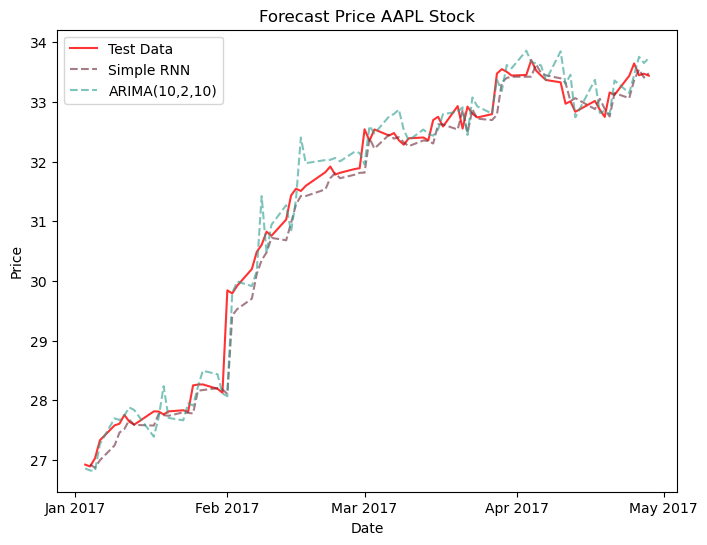

In [237]:
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test Data')
plt.plot(df_y_RNN_predict_unscaled_plot['Date'],df_y_RNN_predict_unscaled_plot['Adj Close'],color='#6b2737',alpha=0.6,label='Simple RNN',linestyle='dashed')
#plt.plot(df_y_GRU_predict_unscaled_plot['Date'],df_y_GRU_predict_unscaled_plot['Adj Close'],color='g',alpha=0.6,label='GRU',linestyle='dashed')
#plt.plot(df_y_LSTM_predict_unscaled_plot['Date'],df_y_LSTM_predict_unscaled_plot['Adj Close'],color='orange',alpha=0.6,label='LSTM',linestyle='dashed')
plt.plot(df_Apple_test_p['Date'],predictions_rolling_window,color='#2a9d8f',alpha=0.6,label='ARIMA(10,2,10)',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Forecast Price AAPL Stock')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
plt.savefig('figures/forecast/price_comparison_AAPL_ARIMA1.png')
plt.show()

Let us calculate the MSE for ARIMA.

We need to put our results in a DataFrame in order to use our scaling functions in order to be able to compare meaningfully the MSE with the NN examples.

In [42]:
df_ARIMA1=pd.DataFrame({'Date':df_Apple_test_p['Date'].tolist(),'Adj Close':predictions_rolling_window})

In [43]:
#Only want the scaled ARIMA prediction
_,scaled_array_ARIMA=data_process_array(df_Apple_train_p,df_ARIMA1)

In [44]:
mse_test_ARIMA=mse(scaled_array_test_p[:,0],scaled_array_ARIMA[:,0]).numpy()

print(f'For Simple RNN, MSE is {mse_test_RNN:.4f}')
print('')
print(f'For ARIMA(10,2,10), MSE is {mse_test_ARIMA:.4f}')

For Simple RNN, MSE is 0.0017

For ARIMA(10,2,10), MSE is 0.0015


The MSE was pretty comparable to the Simple RNN, even a bit smaller, despite visually having more variance then the simple RNN. It is important to recall that we __did not retrain the NN__ on this new data, while by construction we are always fitting a new model every rolling window size with ARIMA.

Let us repeat this exercise with a more complicated ARIMA model

#### ARIMA(30,2,30)

In [220]:
%%time
predictions_rolling_window2 = []
for index,window in enumerate(X_joined_unscaled_p[-81:]):

    if index%10==0:
        print(f'I am here {index}')
    # Fit ARIMA model on the current window
    model = SARIMAX(window, order=(30, 2, 30),verbose=0)  # Adjust (p, d, q) as needed
    model_fit = model.fit(disp=False)
    
    # Predict the next value
    next_value = model_fit.forecast(steps=1)[0]  # Forecasting one step ahead
    predictions_rolling_window2.append(next_value)

I am here 0
I am here 10
I am here 20
I am here 30
I am here 40
I am here 50
I am here 60
I am here 70
I am here 80
CPU times: user 1h 20s, sys: 4min 23s, total: 1h 4min 44s
Wall time: 9min 13s


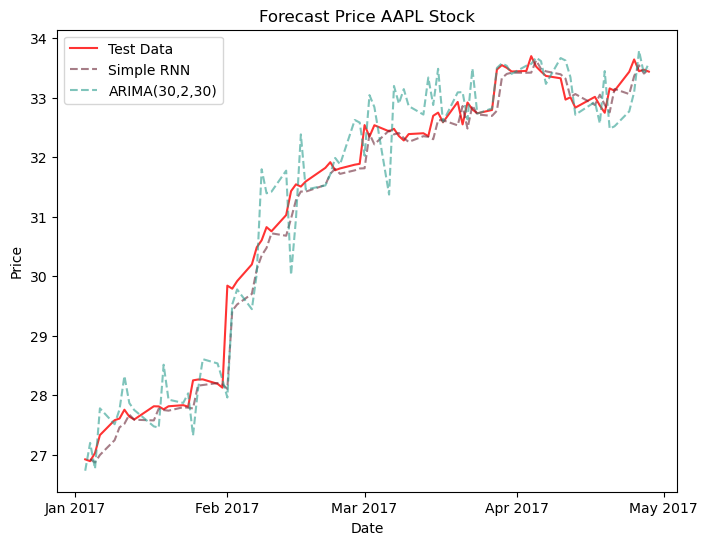

In [238]:
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test Data')
plt.plot(df_y_RNN_predict_unscaled_plot['Date'],df_y_RNN_predict_unscaled_plot['Adj Close'],color='#6b2737',alpha=0.6,label='Simple RNN',linestyle='dashed')
#plt.plot(df_y_GRU_predict_unscaled_plot['Date'],df_y_GRU_predict_unscaled_plot['Adj Close'],color='g',alpha=0.6,label='GRU',linestyle='dashed')
#plt.plot(df_y_LSTM_predict_unscaled_plot['Date'],df_y_LSTM_predict_unscaled_plot['Adj Close'],color='orange',alpha=0.6,label='LSTM',linestyle='dashed')
plt.plot(df_Apple_test_p['Date'],predictions_rolling_window2,color='#2a9d8f',alpha=0.6,label='ARIMA(30,2,30)',linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Forecast Price AAPL Stock')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
plt.savefig('figures/forecast/price_comparison_AAPL_ARIMA2.png')
plt.show()

Let us calculate the MSE again

In [202]:
df_ARIMA2=pd.DataFrame({'Date':df_Apple_test_p['Date'].tolist(),'Adj Close':predictions_rolling_window2})

In [203]:
#Only want the scaled ARIMA prediction
_,scaled_array_ARIMA2=data_process_array(df_Apple_train_p,df_ARIMA2)

In [204]:
mse_test_ARIMA2=mse(scaled_array_test_p[:,0],scaled_array_ARIMA2[:,0]).numpy()

print(f'For Simple RNN, MSE is {mse_test_RNN:.4f}')
print('')
print(f'For ARIMA(10,2,10), MSE is {mse_test_ARIMA:.4f}')
print('')
print(f'For ARIMA(30,2,30), MSE is {mse_test_ARIMA2:.4f}')

For Simple RNN, MSE is 0.0017

For ARIMA(10,2,10), MSE is 0.0015

For ARIMA(30,2,30), MSE is 0.0036


Interestingly, doing a more complicated model increased the MSE instead of getting it to be smaller.

It would be a good future exploration project to do hyperparameter optimization in order to find the best ARIMA models, as well as investigate other metrics in order to evaluate whether the RNN results and ARIMA are really comparable. For instance, ARIMA seems to have much more oscillations around the data than the Neural Network results - so despite similar MSE score, they might give different results in different applications.

## Appendix B - Naive Forecasting

In this appendix, I want to perform a different type of naive forecasting, where we simply cast the previous day data to the next one.

In [214]:
df_Apple_joined_p['Naive_Forecast']=df_Apple_joined_p['Adj Close'].shift(1)

Let us cast the naive forecast to a separate dataframe

In [215]:
df_Apple_NaiveForecast_p=df_Apple_joined_p[['Date','Naive_Forecast']]

Drop the null value due to the lag

In [216]:
df_Apple_NaiveForecast_p.dropna(inplace=True)

/var/folders/qr/7jt362956klf0dnc_163b7nw0000gp/T/ipykernel_963/2783462049.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Apple_NaiveForecast_p.dropna(inplace=True)


In [219]:
# Rename the Naive forecast column in order to use our auxiliary functions
df_Apple_NaiveForecast_p = df_Apple_NaiveForecast_p.rename(columns={"Naive_Forecast": "Adj Close"})


Let us do the scaling in order to compare the mean squared errors to the other methods we will employ

In [221]:
_,scaled_array_naive_p=data_process_array(df_Apple_train_p,df_Apple_NaiveForecast_p)

In [224]:
scaled_array_naive_p.shape

(584, 1)

In [231]:
df_Apple_NaiveForecast_TestRange_p=df_Apple_NaiveForecast_p[df_Apple_NaiveForecast_p['Date'].isin(df_Apple_test_p['Date'])]

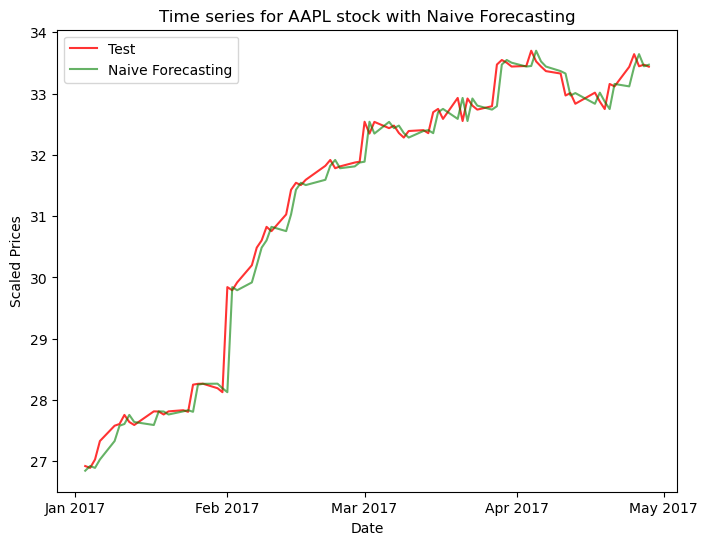

In [233]:
plt.plot(df_Apple_test_p['Date'],df_Apple_test_p['Adj Close'],alpha=0.8,color='red',label='Test')
plt.plot(df_Apple_NaiveForecast_TestRange_p['Date'],df_Apple_NaiveForecast_TestRange_p['Adj Close'],color='green',alpha=0.6,label='Naive Forecasting')
plt.xlabel('Date')
plt.ylabel('Scaled Prices')
plt.title('Time series for AAPL stock with Naive Forecasting')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

Let us calculate the MSE

In [237]:
mse_naive=mse(scaled_array_test_p[:,0],scaled_array_naive_p[-81:,0]).numpy()

In [241]:
print(f'The MSE for the naive forecasting is {mse_naive:.4f}')
print('')
print(f'For Simple RNN, MSE is {mse_test_RNN:.4f}')
print('')
print(f'For ARIMA(10,2,10), MSE is {mse_test_ARIMA:.4f}')

The MSE for the naive forecasting is 0.0009

For Simple RNN, MSE is 0.0017

For ARIMA(10,2,10), MSE is 0.0015


Looking at this result we might think all the analysis we have done did not give any new information, which is not true. MSE is just __one__ metric to evaluate performance. For instance, we could see that the neural network results in general followed the price trend shape pretty closely, so if we want to feed a prediction into a trading strategy, that has much more value than simply saying tha the price the next day will remain the same. In addition, if we forecast 2 or 3 days into the future, then naive forecasting will give even less insight into the future trend of our stocks. 

However, this analysis is interesting in order for us to take small values of MSE with a grain of salt!

## Appendix C - Hyperparameters for Recurrent Neural Network 

Let us investigate running a neural network with a random seed, in order to have reproducibility

The guide for this section for the hyperparameters being tested is:

- __A.__ Hidden State, 40-X-40
- __B.__ Activation function
- __C.__ Dropout
- __D.__ Batch size
- __E.__ Learning rate
- __F.__ Optimizer


I will print here the doc string for the auxiliary function we wrote, we see that most of the hyperparameters have a default value,
but we will vary each of them in the following section.

In [250]:
print(neural_network_run_RNN.__doc__)


    The function to train and fit neural networks! Created the base example the architecture that was mostly successful 
    for all architectures, but still put enough o hyperparameters as optional inputs so we can experiment with them.  

    Input:
    ------
    X_train: Shape (n_input-window,window,1), the training data for the neural network.

    y_train: Shape (n_input-window,1), the value at window+1 used as a target for training.

    experiment: String describing the experiment, useful for labeling the logs. For instance, for a hidden_states experiment, call
    the f-string f'hiddenlayers_{hidden_states}'

    hidden_states: We fix the architecture as 40-hidden_states-40-1, default is hidden_states=80.

    activation: Activation function for the 40-hidden_states-40 layers, default is ReLU.

    dropout: Dropout of nodes, useful to control overfitting when it is important. Default is dropout=0.05.

    flag_optimizer: Default is True. Pass False if you want to include an o

### A. Simple RNN - Hidden States

In this for loop, we will run over different values of hidden states X, for the architecture 40-X-40-1. 

We save the models in a dictionary, so in case there is a need to compare different experiments, we can recover it. 

We manipulate the data just in order to calculate the MSE for test data, and from the history output of the function, we store the loss (which is the MSE of the train data). 

After looping over the states, we can plot and discover which hyperparameters had successsful runs.

In [132]:
scaled_array_train_p, scaled_array_test_p=data_process_array(df_Apple_train_p,df_Apple_test_p)

In [134]:
scaled_joined_p=np.concatenate((scaled_array_train_p, scaled_array_test_p), axis=0)

In [135]:
X_joined_p,y_joined=rolling_window_time_series(scaled_joined_p,40)

In [146]:
list_dates_joined=df_Apple_joined_p['Date'].iloc[40:].tolist()

In [148]:
%%time
hidden_states=[5,10,20,30,40,50,60,70,80,90,100,150,200,400,600]

models_dict_RNN = {}
mse_RNN_test_A=[]
mse_RNN_train_A=[]
for index,hidden in enumerate(hidden_states):
    experiment=f'hiddenlayers_{hidden}'

    model, model_history=neural_network_run_RNN(X_train_p, y_train_p, experiment,hidden_states=hidden)

    
    # Save the model
    
    models_dict_RNN[f'RNN_{experiment}'] = model
    


    # Mean Squared Error Calculation

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_RNN[f'RNN_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()

    #Append to list
    mse_RNN_train_A.append(mse_train)
    mse_RNN_test_A.append(mse_test)
    

Working on experiment hiddenlayers_5
Working on experiment hiddenlayers_10
Working on experiment hiddenlayers_20
Working on experiment hiddenlayers_30
Working on experiment hiddenlayers_40
Working on experiment hiddenlayers_50
Working on experiment hiddenlayers_60
Working on experiment hiddenlayers_70
Working on experiment hiddenlayers_80
Working on experiment hiddenlayers_90
Working on experiment hiddenlayers_100
Working on experiment hiddenlayers_150
Working on experiment hiddenlayers_200
Working on experiment hiddenlayers_400
Working on experiment hiddenlayers_600
CPU times: user 6min 35s, sys: 1min 5s, total: 7min 41s
Wall time: 5min 27s


In [156]:
df_RNN_ExpA=pd.DataFrame({'MSE_train':mse_RNN_train_A,'MSE_test':mse_RNN_test_A},index=hidden_states)
df_RNN_ExpA.index.name = 'Hidden_State'

In [157]:
df_RNN_ExpA.T.head()

Hidden_State,5,10,20,30,40,50,60,70,80,90,100,150,200,400,600
MSE_train,0.002667,0.003035,0.002644,0.002754,0.002677,0.002810,0.003108,0.002921,0.002879,0.002693,0.002815,0.003148,0.002953,0.002988,0.003145
MSE_test,0.004437,0.017295,0.010297,0.008841,0.000864,0.001989,0.001317,0.006009,0.001716,0.001531,0.010029,0.000888,0.000890,0.001621,0.000839


In the spirit of simplicity, it seems that hidden layer $= 80$ was a good trade-off between less parameters and good test MSE score.

### B. Simple RNN - Activation functions

I will naively test the activation function: change all to the one being tested. 

In [158]:
%%time
activation=['ReLU','sigmoid','tanh']
mse_RNN_test_B=[]
mse_RNN_train_B=[]
for func in activation:
    experiment=f'activation_{func}'
    
    model, model_history=neural_network_run_RNN(X_train_p, y_train_p, experiment, activation=func)

    models_dict_RNN[f'RNN_{experiment}']=model

    
    # Mean Squared Error Calculation


    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_RNN[f'RNN_{experiment}'].predict(X_joined_p,verbose=0)

    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data

    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_RNN_train_B.append(mse_train)
    mse_RNN_test_B.append(mse_test)
    
    

Working on experiment activation_ReLU
Working on experiment activation_sigmoid
Working on experiment activation_tanh
CPU times: user 47.6 s, sys: 5.57 s, total: 53.2 s
Wall time: 47.5 s


In [160]:
df_RNN_ExpB=pd.DataFrame({'MSE_train':mse_RNN_train_B,'MSE_test':mse_RNN_test_B},index=activation)
df_RNN_ExpB.index.name = 'activation'
df_RNN_ExpB.T.head()

activation,ReLU,sigmoid,tanh
MSE_train,0.002879,0.335263,0.003714
MSE_test,0.001716,1.403110,0.038508


We see `ReLU` was the best one by far.

### C. Simple RNN - Dropout 

In [161]:
%%time
dropouts=[0.01,0.05,0.1,0.2,0.4,0.6,0.8,0.9]
mse_RNN_test_C=[]
mse_RNN_train_C=[]
for index,dropout in enumerate(dropouts):
    print(f'Working on case i={index}')

    experiment=f'dropout_{dropout}'
    

    model, model_history=neural_network_run_RNN(X_train_p, y_train_p, experiment,dropout=dropout)
    


    # Mean Squared Error Calculation


    # Save the model
    models_dict_RNN[f'RNN_{experiment}'] = model


    # Now let us add the prediction for MSE on test data

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_RNN[f'RNN_{experiment}'].predict(X_joined_p,verbose=0)

    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_RNN_train_C.append(mse_train)
    mse_RNN_test_C.append(mse_test)

Working on case i=0
Working on experiment dropout_0.01
Working on case i=1
Working on experiment dropout_0.05
Working on case i=2
Working on experiment dropout_0.1
Working on case i=3
Working on experiment dropout_0.2
Working on case i=4
Working on experiment dropout_0.4
Working on case i=5
Working on experiment dropout_0.6
Working on case i=6
Working on experiment dropout_0.8
Working on case i=7
Working on experiment dropout_0.9
CPU times: user 2min 36s, sys: 18.3 s, total: 2min 54s
Wall time: 2min 35s


In [162]:
df_RNN_ExpC=pd.DataFrame({'MSE_train':mse_RNN_train_C,'MSE_test':mse_RNN_test_C},index=dropouts)
df_RNN_ExpC.index.name = 'Dropout'
df_RNN_ExpC.T.head()

Dropout,0.01,0.05,0.10,0.20,0.40,0.60,0.80,0.90
MSE_train,0.002535,0.002879,0.003056,0.003476,0.004840,0.004820,0.005271,0.007398
MSE_test,0.010695,0.001716,0.002949,0.008392,0.074196,0.215155,0.515676,0.838158


There is certainly space to increase the dropout (up to 0.2 possibly), but we will keep it at 0.05.

### D. Simple RNN - Batch Size 

The auxiliary function `neural_network_run_RNN` deals with how to calculate save frequency given a batch size.

In [163]:
%%time
batch_sizes=[2,4,8,16,32]
mse_RNN_test_D=[]
mse_RNN_train_D=[]
for batch in batch_sizes:

    experiment=f'batch_{batch}'

    model, model_history=neural_network_run_RNN(X_train_p, y_train_p, experiment, batch_size=batch)


    
    # Mean Squared Error Calculation

    # Save the model
    models_dict_RNN[f'RNN_{experiment}'] = model



    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_RNN[f'RNN_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_RNN_train_D.append(mse_train)
    mse_RNN_test_D.append(mse_test)

Working on experiment batch_2
Working on experiment batch_4
Working on experiment batch_8
Working on experiment batch_16
Working on experiment batch_32
CPU times: user 38.1 s, sys: 4.91 s, total: 43 s
Wall time: 37.9 s


In [164]:
df_RNN_ExpD=pd.DataFrame({'MSE_train':mse_RNN_train_D,'MSE_test':mse_RNN_test_D},index=batch_sizes)
df_RNN_ExpD.index.name = 'batch_size'
df_RNN_ExpD.T.head()

batch_size,2,4,8,16,32
MSE_train,0.002879,0.002734,0.002892,0.002162,0.002806
MSE_test,0.001716,0.010871,0.002873,0.005764,0.001145


Batch size $=2$ was successful. Bigger batch size also performed well, but for the sake of simplicity, we will keep 2.

### E. Simple RNN - Learning Rate 

In [165]:
%%time
learning_rates=[0.000001,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01]
mse_RNN_test_E=[]
mse_RNN_train_E=[]
for lr in learning_rates:
    experiment=f'lr_{lr}'

    model, model_history=neural_network_run_RNN(X_train_p, y_train_p, experiment, learning_rate=lr)


    
    # Mean Squared Error Calculation

    # Save the model
    models_dict_RNN[f'RNN_{experiment}'] = model

   

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_RNN[f'RNN_{experiment}'].predict(X_joined_p,verbose=0)

    #Scale back 
    #y_predict_O = scaler_p.inverse_transform(y_predict)

    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_RNN_train_E.append(mse_train)
    mse_RNN_test_E.append(mse_test)

Working on lr_1e-06
Working on experiment lr_1e-06
Working on lr_1e-05
Working on experiment lr_1e-05
Working on lr_5e-05
Working on experiment lr_5e-05
Working on lr_0.0001
Working on experiment lr_0.0001
Working on lr_0.0005
Working on experiment lr_0.0005
Working on lr_0.001
Working on experiment lr_0.001
Working on lr_0.005
Working on experiment lr_0.005
Working on lr_0.01
Working on experiment lr_0.01
CPU times: user 2min 39s, sys: 18.2 s, total: 2min 57s
Wall time: 2min 38s


In [166]:
df_RNN_ExpE=pd.DataFrame({'MSE_train':mse_RNN_train_E,'MSE_test':mse_RNN_test_E},index=learning_rates)
df_RNN_ExpE.index.name = 'learning_rate'
df_RNN_ExpE.T.head()

learning_rate,0.000001,0.000010,0.000050,0.000100,0.000500,0.001000,0.005000,0.010000
MSE_train,0.027058,0.005572,0.002983,0.002490,0.002796,0.002879,0.004221,0.005648
MSE_test,0.118677,0.007019,0.005423,0.007451,0.003708,0.001716,0.000920,0.006847


This was good, maybe makes sense to focus around 0.0005 and 0.001

In [167]:
%%time
learning_rates2=[0.0005,0.0006,0.0007,0.0008,0.0009,0.001,0.002,0.003,0.004,0.005]
mse_RNN_test_E2=[]
mse_RNN_train_E2=[]
for lr in learning_rates2:
    experiment=f'lr_{lr}'

    model, model_history=neural_network_run_RNN(X_train_p, y_train_p, experiment, learning_rate=lr)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_RNN[f'RNN_{experiment}'] = model



    # Now let us add the prediction for MSE on test data

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_RNN[f'RNN_{experiment}'].predict(X_joined_p,verbose=0)

    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_RNN_train_E2.append(mse_train)
    mse_RNN_test_E2.append(mse_test)

Working on experiment lr_0.0005
Working on experiment lr_0.0006
Working on experiment lr_0.0007
Working on experiment lr_0.0008
Working on experiment lr_0.0009
Working on experiment lr_0.001
Working on experiment lr_0.002
Working on experiment lr_0.003
Working on experiment lr_0.004
Working on experiment lr_0.005
CPU times: user 2min 46s, sys: 19.2 s, total: 3min 6s
Wall time: 2min 49s


In [168]:
df_RNN_ExpE2=pd.DataFrame({'MSE_train':mse_RNN_train_E2,'MSE_test':mse_RNN_test_E2},index=learning_rates2)
df_RNN_ExpE2.index.name = 'learning_rate'
df_RNN_ExpE2.T.head()

learning_rate,0.0005,0.0006,0.0007,0.0008,0.0009,0.0010,0.0020,0.0030,0.0040,0.0050
MSE_train,0.002796,0.002884,0.002746,0.003148,0.002916,0.002879,0.003174,0.003699,0.003844,0.004221
MSE_test,0.003708,0.010059,0.003368,0.002369,0.001885,0.001716,0.001086,0.000866,0.007859,0.000920


Learning rate of 0.001 seems to be the best option still.

### F. Simple RNN - Optimizer 

In [169]:
list_optimizers=['Adam','Nadam','RMSprop','Adagrad','SGD']
list_optimizers_params=['Adam(learning_rate=0.001)','Nadam(learning_rate=0.001)','RMSprop(learning_rate=0.001)',\
                        'Adagrad(learning_rate=0.001)','SGD(learning_rate=0.001, momentum=0.9, nesterov=True)']



In [170]:
mse_RNN_test_F=[]
mse_RNN_train_F=[]
for index,opt in enumerate(list_optimizers):
   
    experiment=f'opt_{opt}'

    if opt=='SGD':
        model, model_history=neural_network_run_RNN(X_train_p, y_train_p, experiment,\
                                                    flag_optimizer=False,optimizer='SGD(learning_rate=0.001, momentum=0.9, nesterov=True)')
    else:
        model, model_history=neural_network_run_RNN(X_train_p, y_train_p, experiment,\
                                                    optimizer=opt)
        
  
    # Mean Squared Error Calculation

    # Save the model
    models_dict_RNN[f'RNN_{experiment}'] = model


    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_RNN[f'RNN_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_RNN_train_F.append(mse_train)
    mse_RNN_test_F.append(mse_test)

Working on experiment opt_Adam
Working on experiment opt_Nadam
Working on experiment opt_RMSprop
Working on experiment opt_Adagrad
Working on experiment opt_SGD


In [171]:
df_RNN_ExpF=pd.DataFrame({'MSE_train':mse_RNN_train_F,'MSE_test':mse_RNN_test_F},index=list_optimizers)
df_RNN_ExpF.index.name = 'list_optimizers'
df_RNN_ExpF.T.head()

list_optimizers,Adam,Nadam,RMSprop,Adagrad,SGD
MSE_train,0.002879,0.002556,0.002862,0.004723,0.003238
MSE_test,0.001716,0.001416,0.004852,0.004185,0.007942


Both `Adam` and `Nadam` performed well, `SGD` was definitely the worst to generalize to unseen data (but it also contains more hyperparameters). We will use `Adam`.

## Appendix D - Hyperparameters for GRU 

The guide for this section follows from the previous one.  The hyperparameters being tested are:

- __A.__ Hidden State, 40-X-40
- __B.__ Activation function
- __C.__ Dropout
- __D.__ Batch size
- __E.__ Learning rate
- __F.__ Optimizer


One important reminder: the structure of this section is very similar to the previous one, but we call a different auxiliary function,
`neural_network_run_GRU`, since we need to call the GRU layers in the model.

## A. GRU - Hidden States

In [172]:
%%time
hidden_states=[5,10,20,30,40,50,60,70,80,90,100,150,200,400,600]
models_dict_GRU = {}
mse_GRU_test_A=[]
mse_GRU_train_A=[]
for index,hidden in enumerate(hidden_states):
    experiment=f'hiddenlayers_{hidden}'

    
    
    model, model_history=neural_network_run_GRU(X_train_p, y_train_p, experiment, hidden_states=hidden)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_GRU[f'GRU_{experiment}'] = model



    # Now let us add the prediction for MSE on test data
    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_GRU[f'GRU_{experiment}'].predict(X_joined_p,verbose=0)

    #Scale back 
    #y_predict_O = scaler_p.inverse_transform(y_predict)

    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_GRU_train_A.append(mse_train)
    mse_GRU_test_A.append(mse_test)
    

Working on experiment hiddenlayers_5
Working on experiment hiddenlayers_10
Working on experiment hiddenlayers_20
Working on experiment hiddenlayers_30
Working on experiment hiddenlayers_40
Working on experiment hiddenlayers_50
Working on experiment hiddenlayers_60
Working on experiment hiddenlayers_70
Working on experiment hiddenlayers_80
Working on experiment hiddenlayers_90
Working on experiment hiddenlayers_100
Working on experiment hiddenlayers_150
Working on experiment hiddenlayers_200
Working on experiment hiddenlayers_400
Working on experiment hiddenlayers_600
CPU times: user 14min 47s, sys: 2min 30s, total: 17min 18s
Wall time: 9min 58s


In [173]:
df_GRU_ExpA=pd.DataFrame({'MSE_train':mse_GRU_train_A,'MSE_test':mse_GRU_test_A},index=hidden_states)
df_GRU_ExpA.index.name = 'Hidden_State'
df_GRU_ExpA.T.head()

Hidden_State,5,10,20,30,40,50,60,70,80,90,100,150,200,400,600
MSE_train,0.003069,0.003184,0.003130,0.003072,0.002743,0.00284,0.335263,0.335263,0.002873,0.002867,0.003204,0.335263,0.002880,0.003204,0.003154
MSE_test,0.010155,0.004459,0.005749,0.007928,0.002729,0.00332,1.403110,1.403110,0.001129,0.003445,0.002621,1.403110,0.001119,0.003296,0.001754


Still seems like 80 was a good option with this learning rate. 

### B. GRU - Activation functions

I will naively test the activation function: change all to the one being tested. 

In [205]:
%%time
#tf.debugging.set_log_device_placement(False)  # Disable device placement debug logs

# Global settings for suppressing warnings and logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow logs
warnings.filterwarnings("ignore")         # Suppress Python warnings
tf.get_logger().setLevel('ERROR')         # Suppress TensorFlow Python-side logs
tf.debugging.set_log_device_placement(False)  # Disable device placement logs
activation=['ReLU','sigmoid','tanh']
mse_GRU_test_B=[]
mse_GRU_train_B=[]
for func in activation:
    warnings.filterwarnings("ignore")

    experiment=f'activation_{func}'
                       
    
    model, model_history=neural_network_run_GRU(X_train_p, y_train_p, experiment, activation=func)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_GRU[f'GRU_{experiment}'] = model



    # Now let us add the prediction for MSE on test data

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_GRU[f'GRU_{experiment}'].predict(X_joined_p,verbose=0)

    #Scale back 
    #y_predict_O = scaler_p.inverse_transform(y_predict)

    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data

    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_GRU_train_B.append(mse_train)
    mse_GRU_test_B.append(mse_test)
    
    

Working on experiment activation_ReLU
Working on experiment activation_sigmoid
Working on experiment activation_tanh


2024-12-13 07:27:56.880469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-13 07:27:56.881168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-13 07:27:56.881943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

CPU times: user 1min 27s, sys: 8.84 s, total: 1min 36s
Wall time: 1min 37s


In [175]:
df_GRU_ExpB=pd.DataFrame({'MSE_train':mse_GRU_train_B,'MSE_test':mse_GRU_test_B},index=activation)
df_GRU_ExpB.index.name = 'activation'
df_GRU_ExpB.T.head()

activation,ReLU,sigmoid,tanh
MSE_train,0.002873,0.335263,0.335263
MSE_test,0.001129,1.403110,1.403110


`Relu` still the most succesful.

### C. GRU - Dropout 

In [176]:
%%time
dropouts=[0.01,0.05,0.1,0.2,0.4,0.6,0.8,0.9]
mse_GRU_test_C=[]
mse_GRU_train_C=[]
for index,dropout in enumerate(dropouts):

    experiment=f'dropout_{dropout}'
    
   
    model, model_history=neural_network_run_GRU(X_train_p, y_train_p, experiment, dropout=dropout)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_GRU[f'GRU_{experiment}'] = model



    # Now let us add the prediction for MSE on test data

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_GRU[f'GRU_{experiment}'].predict(X_joined_p,verbose=0)

    #Scale back 
    #y_predict_O = scaler_p.inverse_transform(y_predict)

    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_GRU_train_C.append(mse_train)
    mse_GRU_test_C.append(mse_test)

Working on experiment dropout_0.01
Working on experiment dropout_0.05
Working on experiment dropout_0.1
Working on experiment dropout_0.2
Working on experiment dropout_0.4
Working on experiment dropout_0.6
Working on experiment dropout_0.8
Working on experiment dropout_0.9
CPU times: user 5min, sys: 27.5 s, total: 5min 28s
Wall time: 5min


In [177]:
df_GRU_ExpC=pd.DataFrame({'MSE_train':mse_GRU_train_C,'MSE_test':mse_GRU_test_C},index=dropouts)
df_GRU_ExpC.index.name = 'Dropout'
df_GRU_ExpC.T.head()

Dropout,0.01,0.05,0.10,0.20,0.40,0.60,0.80,0.90
MSE_train,0.00270,0.002873,0.003327,0.003744,0.003816,0.003710,0.004380,0.007259
MSE_test,0.00383,0.001129,0.001506,0.008799,0.045679,0.236022,0.686285,0.867683


Once again, there is room for increasing the dropout, but we will keep it at 0.05.

### D. GRU - Batch Size 

Remember we need to modify our save frequency parameter!

In [178]:
%%time
batch_sizes=[2,4,8,16,32]
mse_GRU_test_D=[]
mse_GRU_train_D=[]
for batch in batch_sizes:

    experiment=f'batch_{batch}'

  
    model, model_history=neural_network_run_GRU(X_train_p, y_train_p, experiment, batch_size=batch)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_GRU[f'GRU_{experiment}'] = model

    # Now let us add the prediction for MSE on test data

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_GRU[f'GRU_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_GRU_train_D.append(mse_train)
    mse_GRU_test_D.append(mse_test)

Working on experiment batch_2
Working on experiment batch_4
Working on experiment batch_8
Working on experiment batch_16
Working on experiment batch_32
CPU times: user 1min 29s, sys: 8.62 s, total: 1min 38s
Wall time: 1min 28s


In [179]:
df_GRU_ExpD=pd.DataFrame({'MSE_train':mse_GRU_train_D,'MSE_test':mse_GRU_test_D},index=batch_sizes)
df_GRU_ExpD.index.name = 'batch_size'
df_GRU_ExpD.T.head()

batch_size,2,4,8,16,32
MSE_train,0.002873,0.002621,0.002614,0.002815,0.003178
MSE_test,0.001129,0.008599,0.002310,0.007983,0.003155


Batch size 2 was the best.

## E. GRU - Learning Rates

In [180]:
%%time
learning_rates=[0.000001,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01]
mse_GRU_test_E=[]
mse_GRU_train_E=[]
for lr in learning_rates:
    experiment=f'lr_{lr}'


    model, model_history=neural_network_run_GRU(X_train_p, y_train_p, experiment, learning_rate=lr)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_GRU[f'GRU_{experiment}'] = model


    # Now let us add the prediction for MSE on test data

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_GRU[f'GRU_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_GRU_train_E.append(mse_train)
    mse_GRU_test_E.append(mse_test)
    


Working on experiment lr_1e-06
Working on experiment lr_1e-05
Working on experiment lr_5e-05
Working on experiment lr_0.0001
Working on experiment lr_0.0005
Working on experiment lr_0.001
Working on experiment lr_0.005
Working on experiment lr_0.01
CPU times: user 5min 3s, sys: 27.4 s, total: 5min 31s
Wall time: 5min 2s


In [181]:
df_GRU_ExpE=pd.DataFrame({'MSE_train':mse_GRU_train_E,'MSE_test':mse_GRU_test_E},index=learning_rates)
df_GRU_ExpE.index.name = 'learning_rate'
df_GRU_ExpE.T.head()

learning_rate,0.000001,0.000010,0.000050,0.000100,0.000500,0.001000,0.005000,0.010000
MSE_train,0.217077,0.006225,0.003794,0.003158,0.002684,0.002873,0.003415,0.003941
MSE_test,0.977251,0.009688,0.006194,0.005112,0.001818,0.001129,0.001689,0.001892


## F - GRU optimizers

In [182]:
list_optimizers=['Adam','Nadam','RMSprop','Adagrad','SGD']
list_optimizers_params=['Adam(learning_rate=0.001)','Nadam(learning_rate=0.001)','RMSprop(learning_rate=0.001)',\
                        'Adagrad(learning_rate=0.001)','SGD(learning_rate=0.001, momentum=0.9, nesterov=True)']



In [183]:
mse_GRU_test_F=[]
mse_GRU_train_F=[]
for index,opt in enumerate(list_optimizers):

    experiment=f'opt_{opt}'
    
    if opt=='SGD':
        model, model_history=neural_network_run_GRU(X_train_p, y_train_p, experiment,\
                                                    flag_optimizer=False,optimizer='SGD(learning_rate=0.001, momentum=0.9, nesterov=True)')
    else:
        model, model_history=neural_network_run_GRU(X_train_p, y_train_p, experiment,\
                                                    optimizer=opt)
        
  
    # Mean Squared Error Calculation



    # Save the model
    models_dict_GRU[f'GRU_{experiment}'] = model


    # Now let us add the prediction for MSE on test data

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_GRU[f'GRU_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_GRU_train_F.append(mse_train)
    mse_GRU_test_F.append(mse_test)

Working on experiment opt_Adam
Working on experiment opt_Nadam
Working on experiment opt_RMSprop
Working on experiment opt_Adagrad
Working on experiment opt_SGD


In [184]:
df_GRU_ExpF=pd.DataFrame({'MSE_train':mse_GRU_train_F,'MSE_test':mse_GRU_test_F},index=list_optimizers)
df_GRU_ExpF.index.name = 'list_optimizers'
df_GRU_ExpF.T.head()

list_optimizers,Adam,Nadam,RMSprop,Adagrad,SGD
MSE_train,0.002873,0.002739,0.002986,0.008976,0.005250
MSE_test,0.001129,0.000843,0.001231,0.045085,0.026656


`Adam`, `Nadam` and `RMSprop` seem appropriate, in order to keep similar hyperparameters when possible, I will choose `Adam`. 

## Appendix E - Hyperparameters for LSTM 

The guide for this section follows from the previous ones.  The hyperparameters being tested are:

- __A.__ Hidden State, 40-X-40
- __B.__ Activation function
- __C.__ Dropout
- __D.__ Batch size
- __E.__ Learning rate
- __F.__ Optimizer


Once again, an important reminder: the structure of this section is very similar to the previous ones, but we call a different auxiliary function, `neural_network_run_LSTM`.

## A. LSTM - Hidden States

In [185]:
%%time
#hidden_states=[5,10]
hidden_states=[5,10,20,30,40,50,60,70,80,90,100,150,200,400,600]
models_dict_LSTM = {}
mse_LSTM_test_A=[]
mse_LSTM_train_A=[]
for index,hidden in enumerate(hidden_states):
    experiment=f'hiddenlayers_{hidden}'

    model, model_history=neural_network_run_LSTM(X_train_p, y_train_p, experiment, hidden_states=hidden)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_LSTM[f'LSTM_{experiment}'] = model


    # Now let us add the prediction for MSE on test data

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_LSTM[f'LSTM_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_LSTM_train_A.append(mse_train)
    mse_LSTM_test_A.append(mse_test)
    

Working on experiment hiddenlayers_5
Working on experiment hiddenlayers_10
Working on experiment hiddenlayers_20
Working on experiment hiddenlayers_30
Working on experiment hiddenlayers_40
Working on experiment hiddenlayers_50
Working on experiment hiddenlayers_60
Working on experiment hiddenlayers_70
Working on experiment hiddenlayers_80
Working on experiment hiddenlayers_90
Working on experiment hiddenlayers_100
Working on experiment hiddenlayers_150
Working on experiment hiddenlayers_200
Working on experiment hiddenlayers_400
Working on experiment hiddenlayers_600
CPU times: user 25min 12s, sys: 4min 41s, total: 29min 53s
Wall time: 12min 17s


In [186]:
df_LSTM_ExpA=pd.DataFrame({'MSE_train':mse_LSTM_train_A,'MSE_test':mse_LSTM_test_A},index=hidden_states)
df_LSTM_ExpA.index.name = 'Hidden_State'
df_LSTM_ExpA.T.head()

Hidden_State,5,10,20,30,40,50,60,70,80,90,100,150,200,400,600
MSE_train,0.003994,0.003749,0.335263,0.003823,0.003825,0.335263,0.335263,0.335263,0.003915,0.335263,0.335263,0.335263,0.003986,0.335263,0.003752
MSE_test,0.002968,0.013983,1.403110,0.005399,0.007107,1.403110,1.403110,1.403110,0.007957,1.403110,1.403110,1.403110,0.011679,1.403110,0.015544


Interestingly, it seems many more runs were stuck in a local minima in comparison to the other two architectures.

Hidden state= 80 is still a good option given simplicity and MSE score.

### B. LSTM - Activation functions

I will naively test the activation function: change all to the one being tested. 

In [187]:
%%time
activation=['ReLU','sigmoid','tanh']
mse_LSTM_test_B=[]
mse_LSTM_train_B=[]
for func in activation:
    experiment=f'activation_{func}'
    
 
    model, model_history=neural_network_run_LSTM(X_train_p, y_train_p, experiment, activation=func)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_LSTM[f'LSTM_{experiment}'] = model

    # Now let us add the prediction for MSE on test data

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_LSTM[f'LSTM_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data

    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_LSTM_train_B.append(mse_train)
    mse_LSTM_test_B.append(mse_test)
    
    

Working on experiment activation_ReLU
Working on experiment activation_sigmoid
Working on experiment activation_tanh


2024-12-12 21:28:44.723778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-12-12 21:28:44.724940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-12-12 21:28:44.725337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

CPU times: user 1min 29s, sys: 8.85 s, total: 1min 38s
Wall time: 1min 32s


In [188]:
df_LSTM_ExpB=pd.DataFrame({'MSE_train':mse_LSTM_train_B,'MSE_test':mse_LSTM_test_B},index=activation)
df_LSTM_ExpB.index.name = 'activation'
df_LSTM_ExpB.T.head()

activation,ReLU,sigmoid,tanh
MSE_train,0.003915,0.335263,0.335263
MSE_test,0.007957,1.403110,1.403110


`ReLU` still the best one.

### C. LSTM - Dropout 

In [189]:
%%time
dropouts=[0.01,0.05,0.1,0.2,0.4,0.6,0.8,0.9]
mse_LSTM_test_C=[]
mse_LSTM_train_C=[]
for index,dropout in enumerate(dropouts):

    experiment=f'dropout_{dropout}'

    model, model_history=neural_network_run_LSTM(X_train_p, y_train_p, experiment, dropout=dropout)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_LSTM[f'LSTM_{experiment}'] = model


    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_LSTM[f'LSTM_{experiment}'].predict(X_joined_p,verbose=0)

    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_LSTM_train_C.append(mse_train)
    mse_LSTM_test_C.append(mse_test)

Working on experiment dropout_0.01
Working on experiment dropout_0.05
Working on experiment dropout_0.1
Working on experiment dropout_0.2
Working on experiment dropout_0.4
Working on experiment dropout_0.6
Working on experiment dropout_0.8
Working on experiment dropout_0.9
CPU times: user 5min 36s, sys: 29.9 s, total: 6min 6s
Wall time: 5min 36s


In [190]:
df_LSTM_ExpC=pd.DataFrame({'MSE_train':mse_LSTM_train_C,'MSE_test':mse_LSTM_test_C},index=dropouts)
df_LSTM_ExpC.index.name = 'Dropout'
df_LSTM_ExpC.T.head()

Dropout,0.01,0.05,0.10,0.20,0.40,0.60,0.80,0.90
MSE_train,0.002992,0.003915,0.004318,0.004545,0.005075,0.005947,0.008055,0.009711
MSE_test,0.010460,0.007957,0.004022,0.008841,0.030555,0.082899,0.324966,0.553466


There is space to increase the dropout as before, but will keep it equal to 0.05.

### D. LSTM - Batch Size 

Remember we need to modify our save frequency parameter!

In [191]:
%%time
batch_sizes=[2,4,8,16,32]
mse_LSTM_test_D=[]
mse_LSTM_train_D=[]
for batch in batch_sizes:

    experiment=f'batch_{batch}'

   
    model, model_history=neural_network_run_LSTM(X_train_p, y_train_p, experiment, batch_size=batch)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_LSTM[f'LSTM_{experiment}'] = model
    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_LSTM[f'LSTM_{experiment}'].predict(X_joined_p,verbose=0)

    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_LSTM_train_D.append(mse_train)
    mse_LSTM_test_D.append(mse_test)

Working on experiment batch_2
Working on experiment batch_4
Working on experiment batch_8
Working on experiment batch_16
Working on experiment batch_32
CPU times: user 1min 37s, sys: 9.88 s, total: 1min 47s
Wall time: 1min 37s


In [192]:
df_LSTM_ExpD=pd.DataFrame({'MSE_train':mse_LSTM_train_D,'MSE_test':mse_LSTM_test_D},index=batch_sizes)
df_LSTM_ExpD.index.name = 'batch_size'
df_LSTM_ExpD.T.head()

batch_size,2,4,8,16,32
MSE_train,0.003915,0.003982,0.004573,0.005157,0.006209
MSE_test,0.007957,0.010435,0.007262,0.008882,0.009383


For simplicity, will still kepp batch size=2. Batch size =8 would also be a good option.

## E. LSTM - Learning Rates

In [193]:
%%time
learning_rates=[0.000001,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01]
mse_LSTM_test_E=[]
mse_LSTM_train_E=[]
for lr in learning_rates:
    experiment=f'lr_{lr}'

    

    model, model_history=neural_network_run_LSTM(X_train_p, y_train_p, experiment, learning_rate=lr)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_LSTM[f'LSTM_{experiment}'] = model

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_LSTM[f'LSTM_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_LSTM_train_E.append(mse_train)
    mse_LSTM_test_E.append(mse_test)
    


Working on experiment lr_1e-06
Working on experiment lr_1e-05
Working on experiment lr_5e-05
Working on experiment lr_0.0001
Working on experiment lr_0.0005
Working on experiment lr_0.001
Working on experiment lr_0.005
Working on experiment lr_0.01
CPU times: user 5min 46s, sys: 35.6 s, total: 6min 21s
Wall time: 5min 49s


In [194]:
df_LSTM_ExpE=pd.DataFrame({'MSE_train':mse_LSTM_train_E,'MSE_test':mse_LSTM_test_E},index=learning_rates)
df_LSTM_ExpE.index.name = 'learning_rate'
df_LSTM_ExpE.T.head()

learning_rate,0.000001,0.000010,0.000050,0.000100,0.000500,0.001000,0.005000,0.010000
MSE_train,0.234591,0.015295,0.008816,0.006962,0.004207,0.003915,0.003547,0.004674
MSE_test,1.022833,0.066292,0.011479,0.006060,0.002149,0.007957,0.045963,0.019230


Let us run the learning rates again but with the `RMSprop` optimizer (as we will see performs better)

In [195]:
%%time
learning_rates=[0.000001,0.00001,0.00005,0.0001,0.0005,0.001,0.005,0.01]
mse_LSTM_test_E2=[]
mse_LSTM_train_E2=[]
for lr in learning_rates:
    experiment=f'RMS_lr_{lr}'

   
    model, model_history=neural_network_run_LSTM(X_train_p, y_train_p, experiment, optimizer='RMSprop',learning_rate=lr)

    # Mean Squared Error Calculation

    # Save the model
    models_dict_LSTM[f'LSTM_{experiment}'] = model

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_LSTM[f'LSTM_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_LSTM_train_E2.append(mse_train)
    mse_LSTM_test_E2.append(mse_test)
    


Working on experiment RMS_lr_1e-06
Working on experiment RMS_lr_1e-05
Working on experiment RMS_lr_5e-05
Working on experiment RMS_lr_0.0001
Working on experiment RMS_lr_0.0005
Working on experiment RMS_lr_0.001
Working on experiment RMS_lr_0.005
Working on experiment RMS_lr_0.01
CPU times: user 5min 27s, sys: 12.6 s, total: 5min 39s
Wall time: 5min 34s


In [196]:
df_LSTM_ExpE2=pd.DataFrame({'MSE_train':mse_LSTM_train_E2,'MSE_test':mse_LSTM_test_E2},index=learning_rates)
df_LSTM_ExpE2.index.name = 'learning_rate'
print('RMSprop Optimizer')
df_LSTM_ExpE2.T.head()

RMSprop Optimizer


learning_rate,0.000001,0.000010,0.000050,0.000100,0.000500,0.001000,0.005000,0.010000
MSE_train,0.249008,0.015191,0.009483,0.007372,0.004359,0.003526,0.003678,0.335263
MSE_test,1.083506,0.072235,0.008562,0.005824,0.002570,0.003888,0.030861,1.403110


We could choose learning rate of 0.005, but will keep 0.01 for easier comparison.

## F - LSTM optimizers

In [76]:
list_optimizers=['Adam','Nadam','RMSprop','Adagrad','SGD']
list_optimizers_params=['Adam(learning_rate=0.001)','Nadam(learning_rate=0.001)','RMSprop(learning_rate=0.001)',\
                        'Adagrad(learning_rate=0.001)','SGD(learning_rate=0.001, momentum=0.9, nesterov=True)']



In [197]:
mse_LSTM_test_F=[]
mse_LSTM_train_F=[]
for index,opt in enumerate(list_optimizers):

    experiment=f'opt_{opt}'
    
    if opt=='SGD':
        model, model_history=neural_network_run_LSTM(X_train_p, y_train_p, experiment,\
                                                    flag_optimizer=False,optimizer='SGD(learning_rate=0.001, momentum=0.9, nesterov=True)')
    else:
        model, model_history=neural_network_run_LSTM(X_train_p, y_train_p, experiment,\
                                                    optimizer=opt)
        
  
    # Mean Squared Error Calculation



    # Save the model
    models_dict_LSTM[f'LSTM_{experiment}'] = model


    # Now let us add the prediction for MSE on test data

    # Predict using X_joined, outputs the model prediction in the range X_train[40:] and X_test[:]
    y_predict = models_dict_LSTM[f'LSTM_{experiment}'].predict(X_joined_p,verbose=0)


    # Create a DataFrame with the prediction
    
    df_y_predict=pd.DataFrame({'Date':list_dates_joined,'Adj Close':y_predict[:,0]})

    # Create an array with the predictions only in the dates of y_test, as we want to calculate MSE for the test data.
    
    scaled_array_test_predict=df_y_predict[df_y_predict['Date'].isin(df_Apple_test_p['Date'])]['Adj Close'].values

    # Compare forecasted with the test data
    
    mse_train= model_history.history['loss'][-1]
    mse_test=mse(scaled_array_test_p[:,0],scaled_array_test_predict).numpy()


    #Append to list
    mse_LSTM_train_F.append(mse_train)
    mse_LSTM_test_F.append(mse_test)

Working on experiment opt_Adam
Working on experiment opt_Nadam
Working on experiment opt_RMSprop
Working on experiment opt_Adagrad
Working on experiment opt_SGD


In [198]:
df_LSTM_ExpF=pd.DataFrame({'MSE_train':mse_LSTM_train_F,'MSE_test':mse_LSTM_test_F},index=list_optimizers)
df_LSTM_ExpF.index.name = 'list_optimizers'
df_LSTM_ExpF.T.head()

list_optimizers,Adam,Nadam,RMSprop,Adagrad,SGD
MSE_train,0.003915,0.003470,0.003526,0.014537,0.010136
MSE_test,0.007957,0.006099,0.003888,0.031164,0.018963


`Adam`, `Nadam` and `RMSprop` seem to be reasonable. We will choose `RMSprop`, as it seems to give almost half the test MSE compared to `Adam`.